<span style="font-size: 30px; font-weight: bold;">EDA Overview </span>

<h1>Table of Contents</h1>
<ol>
  <li><a href="#load-datasets">Load Datasets</a></li>
  <li><a href="#total-sales-trends">Total Sales Trends</a></li>
  <li><a href="#category-trends-performance">Category Trends and Performance</a></li>
  <li><a href="#food-trends-snap">Food Trends and SNAP</a></li>
  <li><a href="#sales-by-store">Sales by Store</a></li>
  <li><a href="#items-by-store">Top Items</a></li>
  <li><a href="#price">Price</a></li>
  <li><a href="#seasonal">Seasonal Decomposition</a></li>
  <li><a href="#multi">Multiplicative vs. Additive </a></li>
  <li><a href="#stat">Stationarity Test </a></li>
  <li><a href="#stattest">Differencing for Stationarity </a></li>
  <li><a href="#acf">ACF and PACF</a></li>
  <li><a href="#final">Final Observations</a></li>  
</ol>

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from sktime.transformations.series.date import DateTimeFeatures
from sktime.transformations.series.time_since import TimeSince
from sktime.transformations.series.summarize import WindowSummarizer
import  datetime
from tabulate import tabulate
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

<span id="load-datasets" style="font-size: 30px; font-weight: bold;">Load Datasets</span>

In [2]:
clean_data = Path(r"C:\Users\brian\Desktop\Time Series Predict Unit Sales for Walmart\Clean Dataset")

file_in = clean_data / "data.parquet"
CA_1 = pd.read_parquet(path=file_in, engine="pyarrow", filters=[("store_id", "=", "CA_1")])

In [3]:
CA_2 = pd.read_parquet(path=file_in, engine="pyarrow", filters=[("store_id", "=", "CA_2")])

In [4]:
CA_3 = pd.read_parquet(path=file_in, engine="pyarrow", filters=[("store_id", "=", "CA_3")])

In [5]:
CA_4 = pd.read_parquet(path=file_in, engine="pyarrow", filters=[("store_id", "=", "CA_4")])

In [6]:
TX_1 = pd.read_parquet(path=file_in, engine="pyarrow", filters=[("store_id", "=", "TX_1")])

In [7]:
TX_2 = pd.read_parquet(path=file_in, engine="pyarrow", filters=[("store_id", "=", "TX_2")])

In [8]:
TX_3 = pd.read_parquet(path=file_in, engine="pyarrow", filters=[("store_id", "=", "TX_3")])

In [9]:
WI_1 = pd.read_parquet(path=file_in, engine="pyarrow", filters=[("store_id", "=", "WI_1")])

In [10]:
WI_2 = pd.read_parquet(path=file_in, engine="pyarrow", filters=[("store_id", "=", "WI_2")])

In [11]:
WI_3 = pd.read_parquet(path=file_in, engine="pyarrow", filters=[("store_id", "=", "WI_3")])

In [12]:
datasets = [CA_1, CA_2, CA_3, CA_4, TX_1, TX_2, TX_3, WI_1, WI_2, WI_3]

In [13]:
sales_df = pd.concat(datasets)

In [14]:
sales_df.head()

,id,item_id,dept_id,cat_id,state_id,day,units_sold,date,weekday,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,store_id
0,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA,d_1,3,2011-01-29,Saturday,no_promo,no_promo,no_promo,no_promo,0,0,0,2.0,CA_1
1,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA,d_2,0,2011-01-30,Sunday,no_promo,no_promo,no_promo,no_promo,0,0,0,2.0,CA_1
2,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA,d_3,0,2011-01-31,Monday,no_promo,no_promo,no_promo,no_promo,0,0,0,2.0,CA_1
3,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA,d_4,1,2011-02-01,Tuesday,no_promo,no_promo,no_promo,no_promo,1,1,0,2.0,CA_1
4,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA,d_5,4,2011-02-02,Wednesday,no_promo,no_promo,no_promo,no_promo,1,0,1,2.0,CA_1


In [15]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58327370 entries, 0 to 5832736
Data columns (total 18 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   state_id      category      
 5   day           object        
 6   units_sold    int64         
 7   date          datetime64[ns]
 8   weekday       category      
 9   event_name_1  category      
 10  event_type_1  category      
 11  event_name_2  category      
 12  event_type_2  category      
 13  snap_CA       uint8         
 14  snap_TX       uint8         
 15  snap_WI       uint8         
 16  sell_price    float64       
 17  store_id      category      
dtypes: category(11), datetime64[ns](1), float64(1), int64(1), object(1), uint8(3)
memory usage: 3.0+ GB


<span id="total-sales-trends" style="font-size: 30px; font-weight: bold;">Total Sales Trends: </span>

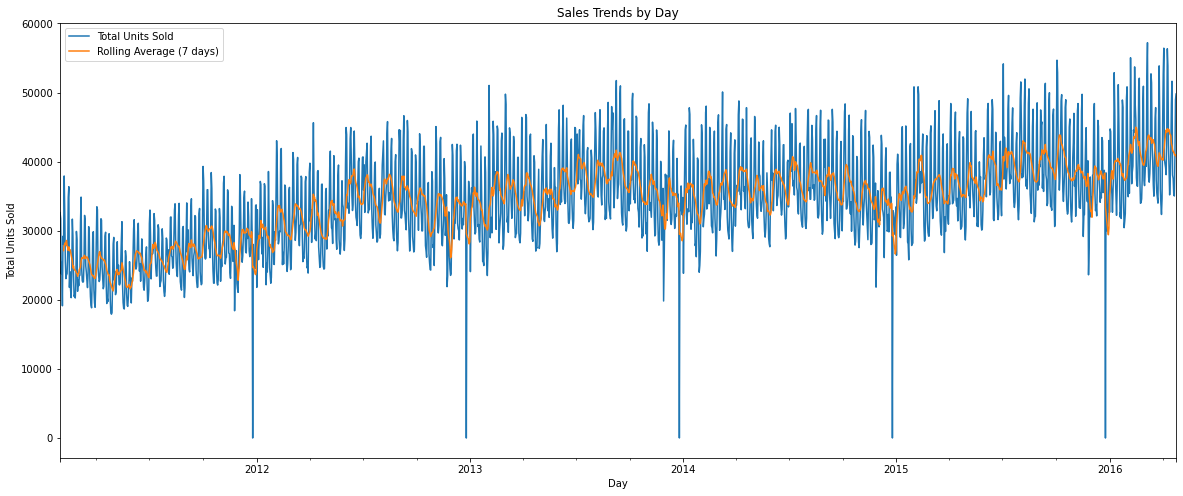

In [16]:
# Aggregate sales by day
sales_by_day = sales_df.groupby('date')['units_sold'].sum()

# Calculate the rolling average with a window size of 7 days
rolling_average = sales_by_day.rolling(window=7).mean()

# Visualize sales trends by day
plt.figure(figsize=(20, 8))
sales_by_day.plot(label='Total Units Sold')
rolling_average.plot(label='Rolling Average (7 days)')
plt.title('Sales Trends by Day')
plt.xlabel('Day')
plt.ylabel('Total Units Sold')
plt.legend()
plt.show()

In [17]:
earliest_date = sales_df['date'].min()
print("Earliest date:", earliest_date)

Earliest date: 2011-01-29 00:00:00


In [18]:
last_date=sales_df['date'].max()
print("Last date:", last_date)

Last date: 2016-04-24 00:00:00


In [19]:
# Filter the dates where sum units sold is less than 5000
low_sales_dates = sales_by_day[sales_by_day < 5000].index

# Print the low sales dates and corresponding sales net
for date in low_sales_dates:
    sales_net = sales_by_day[date]
    print(f"Date: {date}, Sales Net: {sales_net}")

Date: 2011-12-25 00:00:00, Sales Net: 13
Date: 2012-12-25 00:00:00, Sales Net: 11
Date: 2013-12-25 00:00:00, Sales Net: 20
Date: 2014-12-25 00:00:00, Sales Net: 20
Date: 2015-12-25 00:00:00, Sales Net: 14


In [20]:
# Specify the dates and sales net values
dates = [
    '2011-12-25',
    '2012-12-25',
    '2013-12-25',
    '2014-12-25',
    '2015-12-25'
]
sales_nets = [13, 11, 20, 20, 14]

# Iterate over the dates and print the week of year and sales net
for date_str, sales_net in zip(dates, sales_nets):
    date = datetime.datetime.strptime(date_str, '%Y-%m-%d')
    week_of_year = date.isocalendar()[1]
    print(f"Date: {date}, Week of Year: {week_of_year}, Sales Net: {sales_net}")

Date: 2011-12-25 00:00:00, Week of Year: 51, Sales Net: 13
Date: 2012-12-25 00:00:00, Week of Year: 52, Sales Net: 11
Date: 2013-12-25 00:00:00, Week of Year: 52, Sales Net: 20
Date: 2014-12-25 00:00:00, Week of Year: 52, Sales Net: 20
Date: 2015-12-25 00:00:00, Week of Year: 52, Sales Net: 14


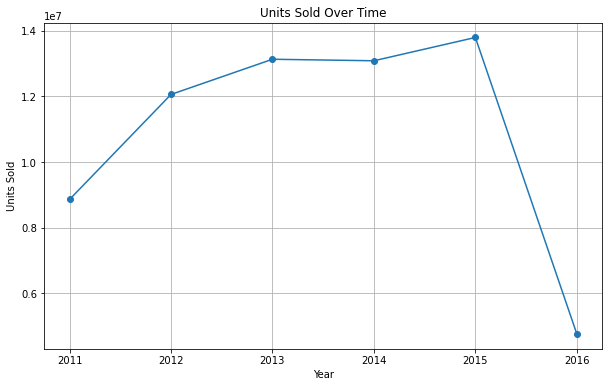

In [21]:
# Extract the year from the date column
sales_df['year'] = sales_df['date'].dt.year

# Group units_sold by year
units_sold_by_year = sales_df.groupby('year')['units_sold'].sum()

# Create a time series plot
plt.figure(figsize=(10, 6))
units_sold_by_year.plot(marker='o')
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.title('Units Sold Over Time')
plt.grid(True)
plt.show()

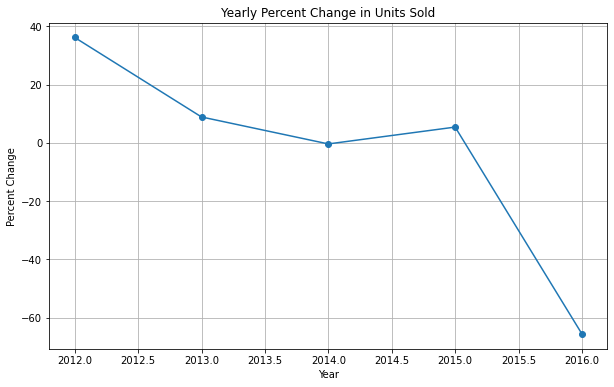

In [22]:
# Calculate the percentage change year over year
percent_change = units_sold_by_year.pct_change() * 100

# Create a line graph
plt.figure(figsize=(10, 6))
percent_change.plot(marker='o')
plt.xlabel('Year')
plt.ylabel('Percent Change')
plt.title('Yearly Percent Change in Units Sold')
plt.grid(True)
plt.show()

<span style="font-size: 16px;"> This graph is less useful than I hoped it would be as the sales data do not start and stop in full years’ worth of time.  Only years 2013, 2014 and 2015 are useful because they hold a full years worth of data.</span>

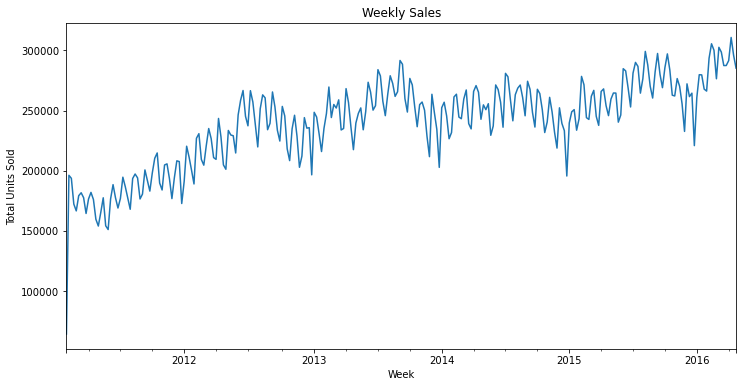

In [23]:
# Set 'date' as the index
sales_df.set_index('date', inplace=True)

# Resample the data to weekly frequency
sales_weekly = sales_df['units_sold'].resample('W').sum()

# Visualize weekly sales
plt.figure(figsize=(12, 6))
sales_weekly.plot()
plt.title('Weekly Sales')
plt.xlabel('Week')
plt.ylabel('Total Units Sold')
plt.show()

In [24]:
# Count the number of unique weeks per year
weeks_per_year = sales_df.index.isocalendar().groupby('year')['week'].nunique()

# Print year and count of weeks per year
for year, count in weeks_per_year.items():
    print(f"Year {year}: {count} weeks")

Year 2011: 49 weeks
Year 2012: 52 weeks
Year 2013: 52 weeks
Year 2014: 52 weeks
Year 2015: 53 weeks
Year 2016: 16 weeks


In [25]:
# Extract year-month-day portion of the date
sales_df['ymd'] = sales_df.index.strftime('%Y-%m-%d')

# Count the number of unique dates per year
unique_dates_per_year = sales_df['ymd'].groupby(sales_df.index.year).nunique()

# Print year and count of unique dates per year
for year, count in unique_dates_per_year.items():
    print(f"Year {year}: {count} unique dates")

Year 2011: 337 unique dates
Year 2012: 366 unique dates
Year 2013: 365 unique dates
Year 2014: 365 unique dates
Year 2015: 365 unique dates
Year 2016: 115 unique dates


In [26]:
# Filter the DataFrame to include only the 3rd quarter dates and exclude 'no_promo' in both event_name_1 and event_name_2
sales_q3 = sales_df[
    (sales_df.index.month >= 7) & 
    (sales_df.index.month <= 9) &
    ~((sales_df['event_name_1'] == 'no_promo') & (sales_df['event_name_2'] == 'no_promo'))
]

# Get the unique event names for the 3rd quarter
unique_event_names = sales_q3[['event_name_1', 'event_name_2']].stack().unique().tolist()

# Print the unique event names
print("Unique Event Names:")
for event_name in unique_event_names:
    print(event_name)

Unique Event Names:
IndependenceDay
no_promo
Ramadan starts
Eid al-Fitr
LaborDay
EidAlAdha


<span id="observations-total-sales-trends" style="font-size: 16px; font-weight: bold;">Observations: Total Sales Trends</span>

<span style="font-size: 16px;"> There is a gradual year over year increase in total sales that can be seen.  There are also obvious seasonal trends in the unit sales.  One day every year, unit sales dip to almost zero.  Upon further investigation I found out this day corresponds to the Christmas holiday. </span>

<span style="font-size: 16px;"> It can also be seen when the sales data is broken up by week, for 2015 there appears to be a 53rd week for sales. The ISO week date system defines the first week of the year as the week that contains the first Thursday of the year. 2015 was not a leap year, but because the first Thursday of the year 2015 falls within the first 7 days of the year, it results in an extra “week”. 
2012 and 2016 are both leap years and will have extra data for February 29th. Just something to keep in mind when forecasting.
 </span>

<span style="font-size: 16px;"> The data reveals two significant trends: a decline in unit sales during the Christmas period and a notable peak in sales during the 3rd quarter of each year. The surge in 3rd quarter sales aligns with the occurrence of Independence Day, which consistently falls on the 4th of July. Additionally, Labor Day, observed on the first Monday of September, marks the end of the quarter and contributes to this sales surge. Furthermore, the timing of Ramadan, an Islamic holiday that follows lunar cycles, varies each year. Here are the dates for Ramadan for the specified years:
 </span>

<ul>
<li><strong>Ramadan starts:</strong>
<ul>
<li>2011: August 1</li>
<li>2012: July 20</li>
<li>2013: July 9</li>
<li>2014: June 29</li>
<li>2015: June 18</li>
<li>2016: June 6</li>
</ul>
</li>
<li><strong>Eid al-Fitr:</strong>
<ul>
<li>2011: August 30</li>
<li>2012: August 19</li>
<li>2013: August 8</li>
<li>2014: July 28</li>
<li>2015: July 17</li>
<li>2016: July 6</li>
</ul>
</li>
<li><strong>EidAlAdha:</strong>
<ul>
<li>2011: November 6</li>
<li>2012: October 26</li>
<li>2013: October 15</li>
<li>2014: October 4</li>
<li>2015: September 23</li>
<li>2016: September 11</li>
</ul>
</li>
</ul>

<span id="category-trends-performance" style="font-size: 30px; font-weight: bold;">Category Trends and Performance: </span>

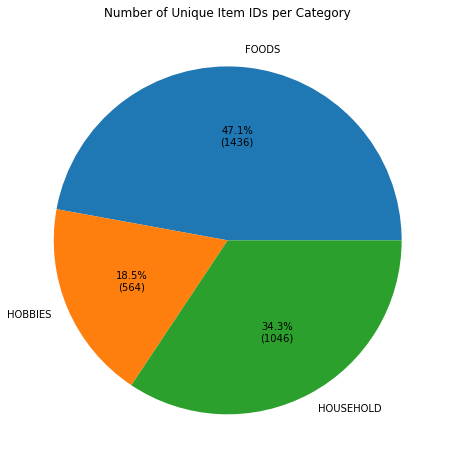

In [27]:
# Count the number of unique item_ids per cat_id
unique_items_per_category = sales_df.groupby('cat_id')['item_id'].nunique()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(unique_items_per_category, labels=unique_items_per_category.index, autopct=lambda pct: f"{pct:.1f}%\n({int(pct * sum(unique_items_per_category) / 100)})")
plt.title('Number of Unique Item IDs per Category')
plt.show()

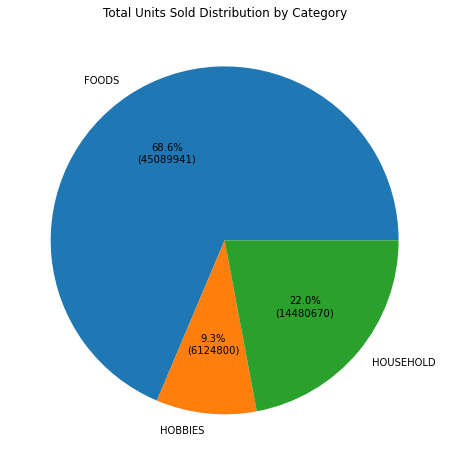

In [28]:
# Calculate the sum of units_sold per cat_id
units_sold_per_category = sales_df.groupby('cat_id')['units_sold'].sum()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(units_sold_per_category, labels=units_sold_per_category.index, autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100*sum(units_sold_per_category))})")
plt.title('Total Units Sold Distribution by Category')
plt.show()

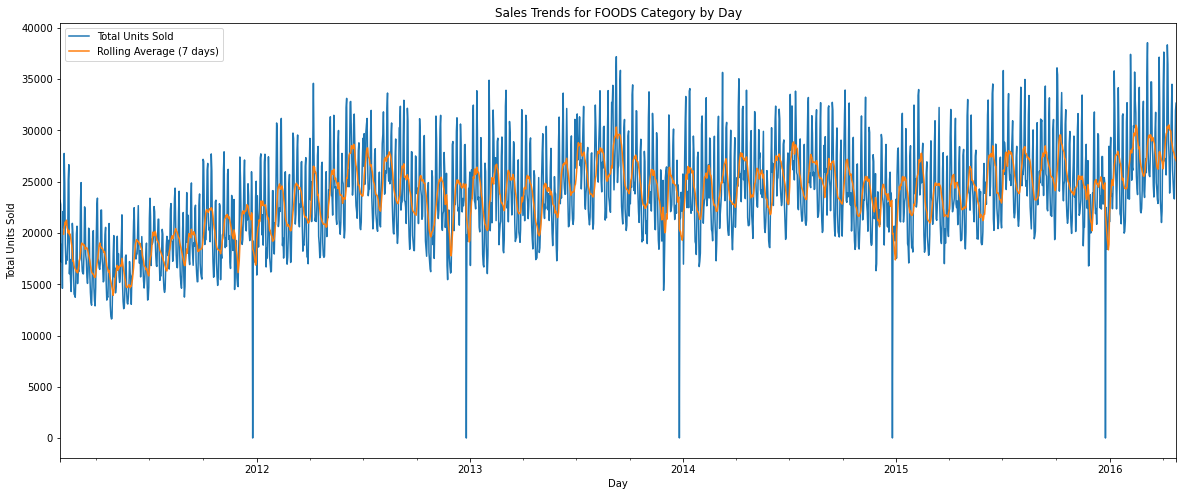

In [29]:
# Filter the DataFrame to include only the FOODS cat_id
foods_sales_df = sales_df[sales_df['cat_id'] == 'FOODS']

# Aggregate sales by day
sales_by_day = foods_sales_df['units_sold'].groupby(foods_sales_df.index).sum()

# Calculate the rolling average with a window size of 7 days
rolling_average = sales_by_day.rolling(window=7).mean()

# Visualize sales trends by day
plt.figure(figsize=(20, 8))
sales_by_day.plot(label='Total Units Sold')
rolling_average.plot(label='Rolling Average (7 days)')
plt.title('Sales Trends for FOODS Category by Day')
plt.xlabel('Day')
plt.ylabel('Total Units Sold')
plt.legend()
plt.show()

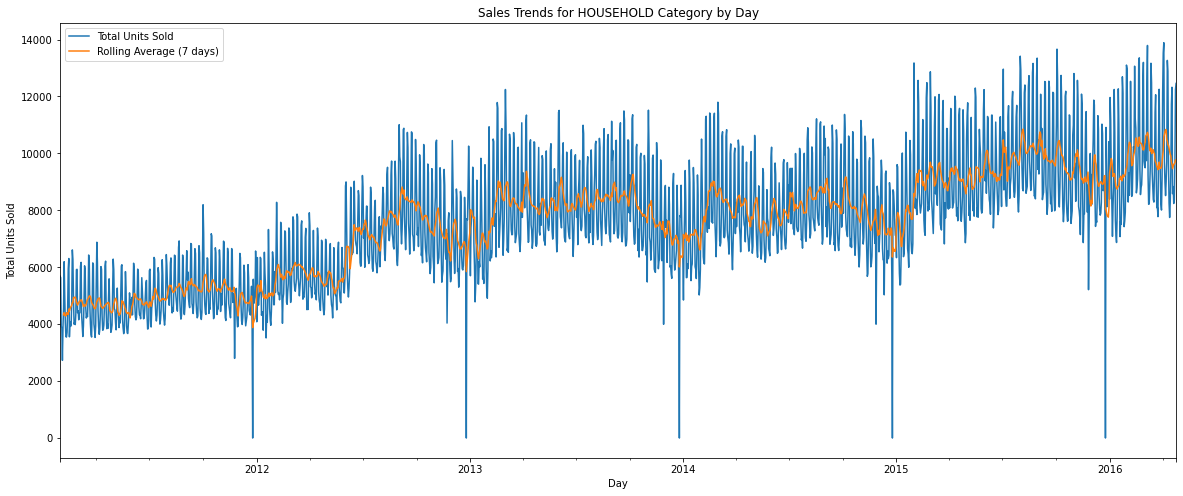

In [30]:
# Filter the DataFrame to include only the HOUSEHOLD cat_id
household_sales_df = sales_df[sales_df['cat_id'] == 'HOUSEHOLD']

# Aggregate sales by day
sales_by_day = household_sales_df['units_sold'].groupby(household_sales_df.index).sum()

# Calculate the rolling average with a window size of 7 days
rolling_average = sales_by_day.rolling(window=7).mean()

# Visualize sales trends by day
plt.figure(figsize=(20, 8))
sales_by_day.plot(label='Total Units Sold')
rolling_average.plot(label='Rolling Average (7 days)')
plt.title('Sales Trends for HOUSEHOLD Category by Day')
plt.xlabel('Day')
plt.ylabel('Total Units Sold')
plt.legend()
plt.show()

In [31]:
# Filter the DataFrame for the year 2015 and the HOUSEHOLD cat_id
household_2015 = sales_df[(sales_df.index.year == 2015) & (sales_df['cat_id'] == 'HOUSEHOLD')]

# Calculate the sum of units sold for each date
units_sold_by_date = household_2015.groupby(household_2015.index.date)['units_sold'].sum()

# Filter for dates with total units sold less than 5800
filtered_dates = units_sold_by_date[units_sold_by_date < 5800].index

# Print the filtered dates
for date in filtered_dates:
    print(date)

2015-01-06
2015-01-07
2015-01-08
2015-11-26
2015-12-25


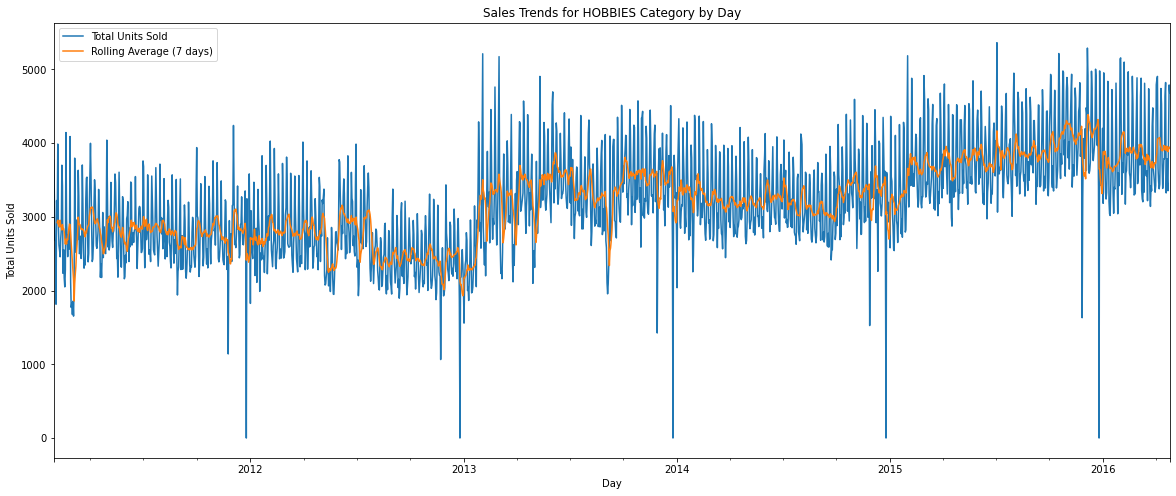

In [32]:
# Filter the DataFrame to include only the HOBBIES cat_id
hobbies_sales_df = sales_df[sales_df['cat_id'] == 'HOBBIES']

# Aggregate sales by day
sales_by_day = hobbies_sales_df['units_sold'].groupby(hobbies_sales_df.index).sum()

# Calculate the rolling average with a window size of 7 days
rolling_average = sales_by_day.rolling(window=7).mean()

# Visualize sales trends by day
plt.figure(figsize=(20, 8))
sales_by_day.plot(label='Total Units Sold')
rolling_average.plot(label='Rolling Average (7 days)')
plt.title('Sales Trends for HOBBIES Category by Day')
plt.xlabel('Day')
plt.ylabel('Total Units Sold')
plt.legend()
plt.show()

In [33]:
# Group the sales_df by cat_id and year, and calculate the sum of units_sold
grouped_sales = sales_df.groupby(['cat_id', sales_df.index.year])['units_sold'].sum()

# Calculate the year-over-year percent change for each cat_id
percent_change = grouped_sales.groupby('cat_id').pct_change() * 100

# Filter the percent_change DataFrame for the years 2013, 2014, and 2015
filtered_percent_change = percent_change.loc[:, [2013, 2014, 2015]]

# Print the year-over-year percent change for each cat_id for the filtered years
for cat_id in filtered_percent_change.index.get_level_values('cat_id').unique():
    print(f"Category: {cat_id}")
    for year in filtered_percent_change.loc[cat_id].index:
        percent = filtered_percent_change.loc[cat_id, year]
        print(f"Year {year}: {percent:.2f}%")
    print()

Category: FOODS
Year 2013: 3.82%
Year 2014: 0.04%
Year 2015: 0.20%

Category: HOBBIES
Year 2013: 25.86%
Year 2014: -2.00%
Year 2015: 17.43%

Category: HOUSEHOLD
Year 2013: 20.25%
Year 2014: -0.88%
Year 2015: 16.71%



In [34]:
# Group the sales data by cat_id and calculate the total units sold for each category
category_sales = sales_df.groupby('cat_id')['units_sold'].sum()

# Sort the categories based on total units sold in descending order
sorted_categories = category_sales.sort_values(ascending=False)

# Calculate the cumulative sum of units sold
cumulative_units_sold = sorted_categories.cumsum()

# Calculate the total units sold
total_units_sold = sorted_categories.sum()

# Find the index position where the cumulative sum exceeds or reaches 80% of the total units sold
threshold = 0.8 * total_units_sold
contributing_categories = sorted_categories[cumulative_units_sold <= threshold]

print("Categories contributing to 80% of units sold:")
print(contributing_categories)

Categories contributing to 80% of units sold:
cat_id
FOODS    45089939
Name: units_sold, dtype: int64


<span id="observations-category-trends-performance" style="font-size: 16px; font-weight: bold;">Observations: Category Trends and Performance</span>

<span style="font-size: 16px;"> 47% of available items for sale fall under the FOOD category. Additionally, the FOOD category dominates the unit sales with a majority share of 68.6%.
The seasonality pattern observed in the overall sales time series is largely influenced by the fluctuations in food sales. Comparing the time series for food sales and total sales, it is evident that food sales play a significant role in driving the overall seasonality. Notably, in the time series graphs for the Hobbies and Household categories, there is a distinct drop in sales observed on Thanksgiving every year, which is celebrated on the fourth Thursday of November. However, the impact of this holiday on the food category is less significant, likely due to last-minute food shopping by customers.  </span>

<span style="font-size: 16px;">Upon examining the year-over-year percent change in unit sales, notable patterns emerge. In 2013, all categories experienced a substantial increase, followed by a significant decline in 2014. However, the food category stands out as the only one that managed to achieve a slight increase of 0.04% in 2014. Moving to 2015, we observe another notable surge in the percent increase, particularly for the Hobbies and Household categories. Among these three categories, food demonstrates a comparatively stable growth trajectory.  In order to delve deeper into the reasons behind the stagnant unit sales in the year 2014, a thorough investigation is necessary, excluding the possibility of a leap year effect. </span>

<span id="food-trends-snap" style="font-size: 30px; font-weight: bold;">Food Trends and SNAP: </span>

<span id="review-price-data" style="font-size: 16px; font-weight: bold;">California</span>

In [35]:
snap_dates_CA = sales_df[sales_df['snap_CA'] == 1].index.unique().tolist()

In [36]:
#Filter the dataset for cat_id == "FOODS"
food_sales_df = sales_df[sales_df['cat_id'] == 'FOODS']

In [37]:
#Group the filtered dataset by state_id
grouped_sales = food_sales_df.groupby('state_id')

CA SNAP benefits are sent out over the first 10 days of every month, based on the last digit of a persons case number.

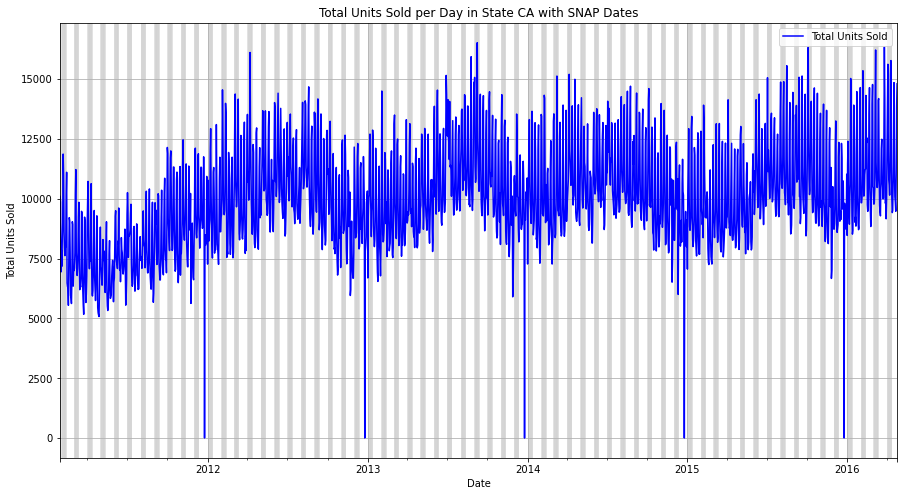

In [38]:
# Filter the sales data for cat_id == "FOODS" and state_id == "CA"
CA_sales = sales_df[(sales_df['cat_id'] == 'FOODS') & (sales_df['state_id'] == 'CA')]

# Calculate the daily sum of units_sold
daily_units_sold_ca = CA_sales['units_sold'].resample('D').sum()

# Plot the time series
plt.figure(figsize=(15, 8))

# Plot the blue graph for daily units sold
daily_units_sold_ca.plot(color='blue', label='Total Units Sold')

# Set plot title and labels
plt.title('Total Units Sold per Day in State CA with SNAP Dates')
plt.xlabel('Date')
plt.ylabel('Total Units Sold')

# Show legend and grid
plt.legend(loc="upper right")
plt.grid(True)

# Add light gray shaded areas for the 1st to 10th of each month
for year in range(2011, 2017):
    for month in range(1, 13):
        for day in range(1, 11):
            date = pd.to_datetime(f'{year}-{month:02d}-{day:02d}')
            if date in CA_sales.index:
                plt.axvspan(date, date + pd.DateOffset(days=1), color='lightgray', alpha=0.5)

# Show the plot
plt.show()

In [39]:
# Filter the SNAP dates for CA_sales
snap_dates_ca = CA_sales[CA_sales['snap_CA'] == 1].index

# Create a boolean mask for SNAP dates in daily_units_sold_ca
snap_dates_mask = daily_units_sold_ca.index.isin(snap_dates_ca)

In [40]:
# Calculate the correlation coefficient and p-value
correlation, p_value = stats.pearsonr(daily_units_sold_ca, snap_dates_mask)

# Print the results
print("Correlation coefficient:", correlation)
print("P-value:", p_value)

Correlation coefficient: 0.22079221146723382
P-value: 1.4922872932909579e-22


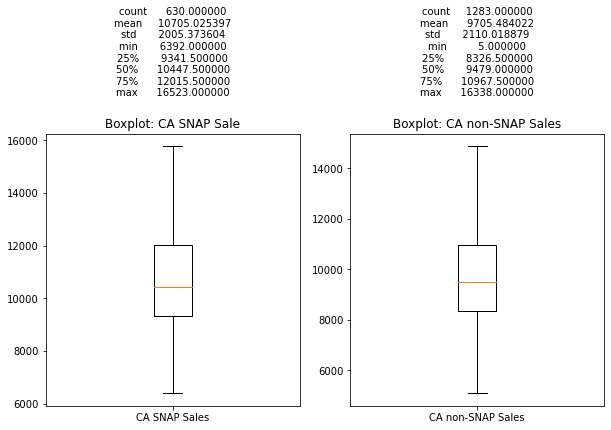

In [41]:
# Filter the sales data for cat_id == "FOODS" and state_id == "CA"
CA_sales = sales_df[(sales_df['cat_id'] == 'FOODS') & (sales_df['state_id'] == 'CA')]

# Calculate the daily sum of units_sold
CA_sold = CA_sales['units_sold'].resample('D').sum()

# Subset the first 10 days of each month
first_10_days = CA_sold[CA_sold.index.day <= 10]

# Subset the remaining days of each month
remaining_days = CA_sold[CA_sold.index.day > 10]
# Create a figure and axis objects
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first 10 days boxplot
ax[0].boxplot(first_10_days, labels=['CA SNAP Sales'], showfliers=False)

# Print the statistical summary for SNAP disbursement days
CAsnap_stats = first_10_days.describe()
ax[0].text(0.5, 1.3, CAsnap_stats.to_string(), transform=ax[0].transAxes, ha='center', va='center')

# Plot the remaining days boxplot
ax[1].boxplot(remaining_days, labels=['CA non-SNAP Sales'], showfliers=False)

# Print the statistical summary for non-SNAP days
CAnon_snap_stats = remaining_days.describe()
ax[1].text(0.5, 1.3, CAnon_snap_stats.to_string(), transform=ax[1].transAxes, ha='center', va='center')

# Set titles for the subplots
ax[0].set_title('Boxplot: CA SNAP Sale')
ax[1].set_title('Boxplot: CA non-SNAP Sales')



#  # Set spacing above the subplots
# fig.subplots_adjust(top=2)


# Display the figure
plt.show()

<span id="review-price-data" style="font-size: 16px; font-weight: bold;">Texas</span>

In [42]:
snap_date_TX = sales_df[sales_df['snap_TX'] == 1].index.unique().tolist()

In [43]:
snap_date_TX 

[Timestamp('2011-02-01 00:00:00'),
 Timestamp('2011-02-03 00:00:00'),
 Timestamp('2011-02-05 00:00:00'),
 Timestamp('2011-02-06 00:00:00'),
 Timestamp('2011-02-07 00:00:00'),
 Timestamp('2011-02-09 00:00:00'),
 Timestamp('2011-02-11 00:00:00'),
 Timestamp('2011-02-12 00:00:00'),
 Timestamp('2011-02-13 00:00:00'),
 Timestamp('2011-02-15 00:00:00'),
 Timestamp('2011-03-01 00:00:00'),
 Timestamp('2011-03-03 00:00:00'),
 Timestamp('2011-03-05 00:00:00'),
 Timestamp('2011-03-06 00:00:00'),
 Timestamp('2011-03-07 00:00:00'),
 Timestamp('2011-03-09 00:00:00'),
 Timestamp('2011-03-11 00:00:00'),
 Timestamp('2011-03-12 00:00:00'),
 Timestamp('2011-03-13 00:00:00'),
 Timestamp('2011-03-15 00:00:00'),
 Timestamp('2011-04-01 00:00:00'),
 Timestamp('2011-04-03 00:00:00'),
 Timestamp('2011-04-05 00:00:00'),
 Timestamp('2011-04-06 00:00:00'),
 Timestamp('2011-04-07 00:00:00'),
 Timestamp('2011-04-09 00:00:00'),
 Timestamp('2011-04-11 00:00:00'),
 Timestamp('2011-04-12 00:00:00'),
 Timestamp('2011-04-

TX benefits are sent out over 15 days, beginning on the 1st and based on the last digit in a persons Eligibility Determination Group (EDG) number. Days are 1, 3, 5, 6, 7, 9, 11, 12, 13, 15

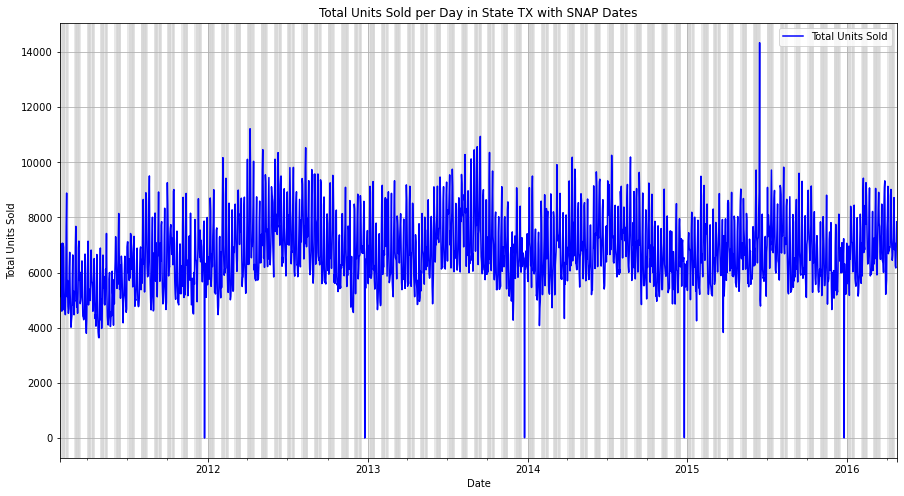

In [44]:
# Filter the sales data for cat_id == "FOODS" and state_id == "TX"
TX_sales = sales_df[(sales_df['cat_id'] == 'FOODS') & (sales_df['state_id'] == 'TX')]

# Calculate the daily sum of units_sold
daily_units_sold_tx = TX_sales['units_sold'].resample('D').sum()

# Plot the time series
plt.figure(figsize=(15, 8))

# Plot the blue graph for daily units sold
daily_units_sold_tx.plot(color='blue', label='Total Units Sold')

# Set plot title and labels
plt.title('Total Units Sold per Day in State TX with SNAP Dates')
plt.xlabel('Date')
plt.ylabel('Total Units Sold')

# Show legend and grid
plt.legend(loc="upper right")
plt.grid(True)

# Add light gray shaded areas for the specified days of each month
for year in range(2011, 2017):
    for month in range(1, 13):
        for day in [1, 3, 5, 6, 7, 9, 11, 12, 13, 15]:
            date = pd.to_datetime(f'{year}-{month:02d}-{day:02d}')
            if date in TX_sales.index:
                plt.axvspan(date, date + pd.DateOffset(days=1), color='lightgray', alpha=0.5)

# Show the plot
plt.show()

In [45]:
# Find the date where daily sales exceed 14,000 units
date_above_threshold = daily_units_sold_tx[daily_units_sold_tx > 14000].index[0]

print("Date with daily sales above 14,000 units:", date_above_threshold)

Date with daily sales above 14,000 units: 2015-06-15 00:00:00


In [46]:
# Filter the sales data for the specific date and State TX
daily_sales_date = TX_sales.loc['2015-06-15']

# Find the item_id with the most units_sold on the specified date
most_sold_item = daily_sales_date[daily_sales_date['units_sold'] == daily_sales_date['units_sold'].max()]
most_sold_item_id = most_sold_item['item_id'].values[0]

# Get the total units sold for the most_sold_item on the specified date
total_units_sold = daily_sales_date[daily_sales_date['item_id'] == most_sold_item_id]['units_sold'].sum()

print("Most sold item on 2015-06-15:", most_sold_item_id)
print("Total units sold for that item on 2015-06-15:", total_units_sold)

Most sold item on 2015-06-15: FOODS_3_090
Total units sold for that item on 2015-06-15: 397


In [47]:
# Filter the sales data for the specific date and State TX
daily_sales_date = TX_sales.loc['2015-06-15']

# Group the sales data by dept_id and calculate the total units sold for each department
dept_sales = daily_sales_date.groupby('dept_id')['units_sold'].sum()

# Find the dept_id with the highest total units sold
highest_selling_dept = dept_sales.idxmax()

# Get the total units sold for the highest selling dept_id on the specified date
total_units_sold = dept_sales.loc[highest_selling_dept]

print("Highest selling dept_id on 2015-06-15:", highest_selling_dept)
print("Total units sold for that dept_id on 2015-06-15:", total_units_sold)

Highest selling dept_id on 2015-06-15: FOODS_3
Total units sold for that dept_id on 2015-06-15: 11175


In [48]:
# Filter the SNAP dates for TX_sales
snap_dates_tx = TX_sales[TX_sales['snap_TX'] == 1].index

# Create a boolean mask for SNAP dates in daily_units_sold_tx
snap_dates_mask_tx= daily_units_sold_tx.index.isin(snap_dates_tx)

In [49]:
# Calculate the correlation coefficient and p-value
correlation, p_value = stats.pearsonr(daily_units_sold_tx, snap_dates_mask_tx)

# Print the results
print("Correlation coefficient:", correlation)
print("P-value:", p_value)

Correlation coefficient: 0.3534216433592311
P-value: 2.2092680112837236e-57


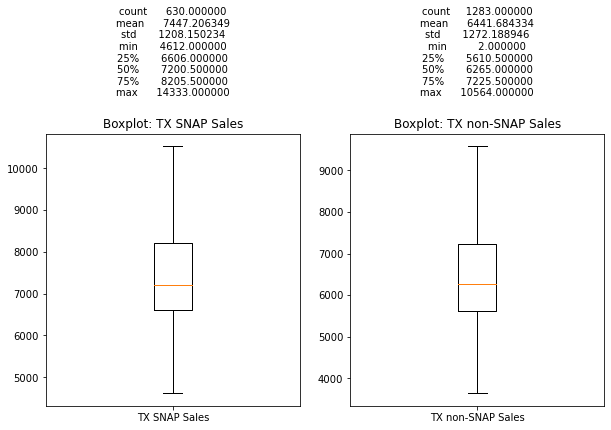

In [50]:
# Filter the sales data for cat_id == "FOODS" and state_id == "TX"
TX_sales = sales_df[(sales_df['cat_id'] == 'FOODS') & (sales_df['state_id'] == 'TX')]

# Calculate the daily sum of units_sold
TX_sold = TX_sales['units_sold'].resample('D').sum()

# Subset the tx snap days
TXSNAPDAY = TX_sold[TX_sold.index.day.isin([1, 3, 5, 6, 7, 9, 11, 12, 13, 15])]

# Subset the remaining days of each month
TX_remaining_days = TX_sold[~TX_sold.index.day.isin([1, 3, 5, 6, 7, 9, 11, 12, 13, 15])]

# Create a figure and axis objects
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first 10 days boxplot
ax[0].boxplot(TXSNAPDAY, labels=['TX SNAP Sales'], showfliers=False)

# Print the statistical summary for SNAP disbursement days
TXsnap_stats = TXSNAPDAY.describe()
ax[0].text(0.5, 1.3, TXsnap_stats.to_string(), transform=ax[0].transAxes, ha='center', va='center')

# Plot the remaining days boxplot
ax[1].boxplot(TX_remaining_days, labels=['TX non-SNAP Sales'], showfliers=False)

# Print the statistical summary for non-SNAP days
TXnon_snap_stats = TX_remaining_days.describe()
ax[1].text(0.5, 1.3, TXnon_snap_stats.to_string(), transform=ax[1].transAxes, ha='center', va='center')

# Set titles for the subplots
ax[0].set_title('Boxplot: TX SNAP Sales')
ax[1].set_title('Boxplot: TX non-SNAP Sales')


# Display the figure
plt.show()

<span id="review-price-data" style="font-size: 16px; font-weight: bold;">Wisconsin</span>

In [51]:
snap_date_WI = sales_df[sales_df['snap_WI'] == 1].index.unique().tolist()

In [52]:
snap_date_WI

[Timestamp('2011-02-02 00:00:00'),
 Timestamp('2011-02-03 00:00:00'),
 Timestamp('2011-02-05 00:00:00'),
 Timestamp('2011-02-06 00:00:00'),
 Timestamp('2011-02-08 00:00:00'),
 Timestamp('2011-02-09 00:00:00'),
 Timestamp('2011-02-11 00:00:00'),
 Timestamp('2011-02-12 00:00:00'),
 Timestamp('2011-02-14 00:00:00'),
 Timestamp('2011-02-15 00:00:00'),
 Timestamp('2011-03-02 00:00:00'),
 Timestamp('2011-03-03 00:00:00'),
 Timestamp('2011-03-05 00:00:00'),
 Timestamp('2011-03-06 00:00:00'),
 Timestamp('2011-03-08 00:00:00'),
 Timestamp('2011-03-09 00:00:00'),
 Timestamp('2011-03-11 00:00:00'),
 Timestamp('2011-03-12 00:00:00'),
 Timestamp('2011-03-14 00:00:00'),
 Timestamp('2011-03-15 00:00:00'),
 Timestamp('2011-04-02 00:00:00'),
 Timestamp('2011-04-03 00:00:00'),
 Timestamp('2011-04-05 00:00:00'),
 Timestamp('2011-04-06 00:00:00'),
 Timestamp('2011-04-08 00:00:00'),
 Timestamp('2011-04-09 00:00:00'),
 Timestamp('2011-04-11 00:00:00'),
 Timestamp('2011-04-12 00:00:00'),
 Timestamp('2011-04-

WI benefits are sent out over the first 15 days of every month, based on the eighth digit of SSN. Days are: 2, 3, 5, 6, 8, 9, 11, 12, 14, 15.

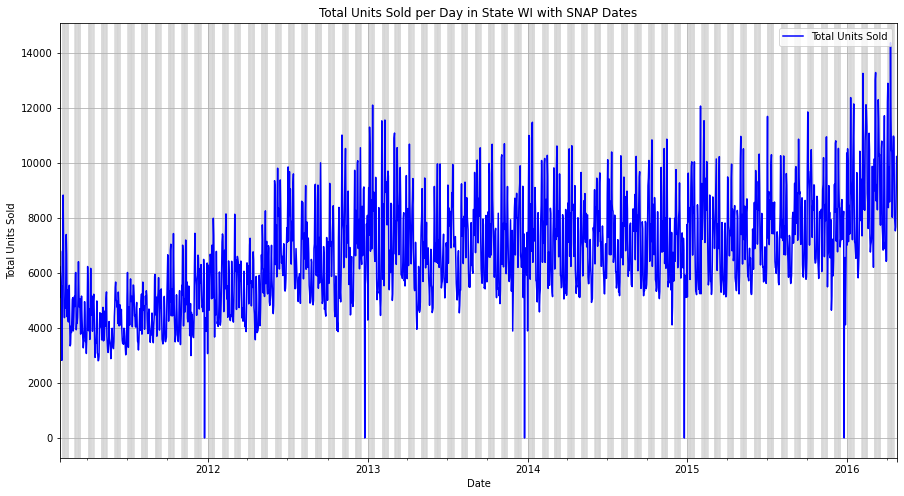

In [53]:
# Filter the sales data for cat_id == "FOODS" and state_id == "WI"
WI_sales = sales_df[(sales_df['cat_id'] == 'FOODS') & (sales_df['state_id'] == 'WI')]

# Calculate the daily sum of units_sold
daily_units_sold_WI = WI_sales['units_sold'].resample('D').sum()

# Plot the time series
plt.figure(figsize=(15, 8))

# Plot the blue graph for daily units sold
daily_units_sold_WI.plot(color='blue', label='Total Units Sold')

# Set plot title and labels
plt.title('Total Units Sold per Day in State WI with SNAP Dates')
plt.xlabel('Date')
plt.ylabel('Total Units Sold')

# Show legend and grid
plt.legend(loc="upper right")
plt.grid(True)

# Add light gray shaded areas for the specified days of each month
for year in range(2011, 2017):
    for month in range(1, 13):
        for day in [2, 3, 5, 6, 8, 9, 11, 12, 14, 15]:
            date = pd.to_datetime(f'{year}-{month:02d}-{day:02d}')
            if date in WI_sales.index:
                plt.axvspan(date, date + pd.DateOffset(days=1), color='lightgray', alpha=0.5)

# Show the plot
plt.show()

In [54]:
# Filter the SNAP dates for WI_sales
snap_dates_WI= WI_sales[WI_sales['snap_WI'] == 1].index

# Create a boolean mask for SNAP dates in daily_units_sold_tx
snap_dates_mask_WI= daily_units_sold_WI.index.isin(snap_dates_WI)

In [55]:
# Calculate the correlation coefficient and p-value
correlation, p_value = stats.pearsonr(daily_units_sold_WI, snap_dates_mask_WI)

# Print the results
print("Correlation coefficient:", correlation)
print("P-value:", p_value)

Correlation coefficient: 0.45330340838534716
P-value: 1.419320864116129e-97


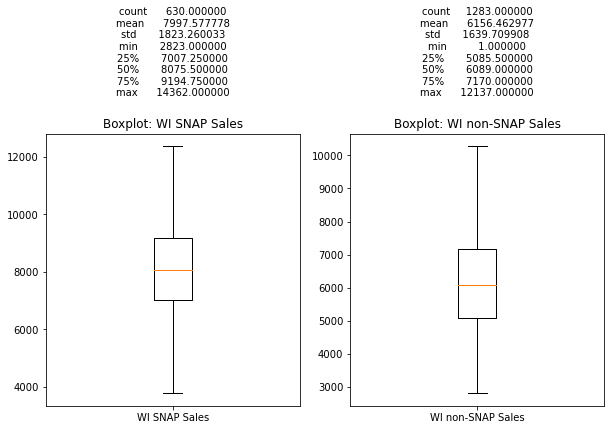

In [56]:
# Filter the sales data for cat_id == "FOODS" and state_id == "WI"
WI_sales = sales_df[(sales_df['cat_id'] == 'FOODS') & (sales_df['state_id'] == 'WI')]

# Calculate the daily sum of units_sold
WI_sold = WI_sales['units_sold'].resample('D').sum()

# Subset the WI snap days
WISNAPDAY = WI_sold[WI_sold.index.day.isin([2, 3, 5, 6, 8, 9, 11, 12, 14, 15])]

# Subset the remaining days of each month
WI_remaining_days = WI_sold[~WI_sold.index.day.isin([2, 3, 5, 6, 8, 9, 11, 12, 14, 15])]

# Create a figure and axis objects
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first 10 days boxplot
ax[0].boxplot(WISNAPDAY, labels=['WI SNAP Sales'], showfliers=False)

# Print the statistical summary for SNAP disbursement days
WIsnap_stats = WISNAPDAY.describe()
ax[0].text(0.5, 1.3, WIsnap_stats.to_string(), transform=ax[0].transAxes, ha='center', va='center')

# Plot the remaining days boxplot
ax[1].boxplot(WI_remaining_days, labels=['WI non-SNAP Sales'], showfliers=False)

# Print the statistical summary for non-SNAP days
WInon_snap_stats = WI_remaining_days.describe()
ax[1].text(0.5, 1.3, WInon_snap_stats.to_string(), transform=ax[1].transAxes, ha='center', va='center')

# Set titles for the subplots
ax[0].set_title('Boxplot: WI SNAP Sales')
ax[1].set_title('Boxplot: WI non-SNAP Sales')


# Display the figure
plt.show()

<span id="observations-food-trends-snap" style="font-size: 16px; font-weight: bold;">Observations: Food Trends and SNAP</span>

<span style="font-size: 16px;"> 
Based on the analysis of the graphs and correlation coefficients with their respective p-values, there is a significant relationship between unit sales and SNAP benefits in all three states. The correlation coefficients indicate small positive correlations, and the very low p-values provide strong evidence against the null hypothesis of no correlation. These correlations can also be observed visually in the graphs, where the gray vertical bars represent SNAP dates and the sales tend to increase during those periods. </span>

<span style="font-size: 16px;"> There are certainly intriguing events in each state that warrant further analysis, such as the occurrence in Texas in 2011 where unit sales exceeded 14000. These outliers require additional investigation to understand the underlying factors contributing to such exceptional sales figures.</span>

<span id="sales-by-store" style="font-size: 30px; font-weight: bold;">Sales by Store </span>

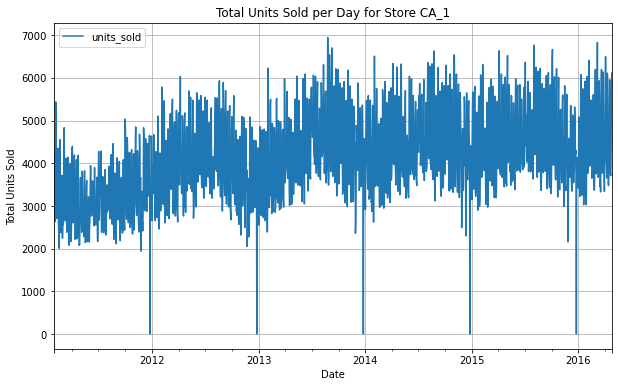

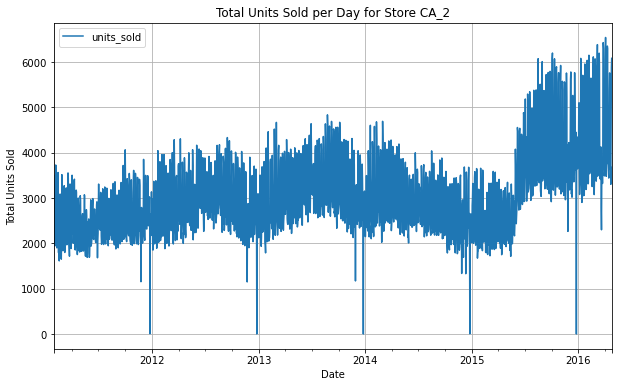

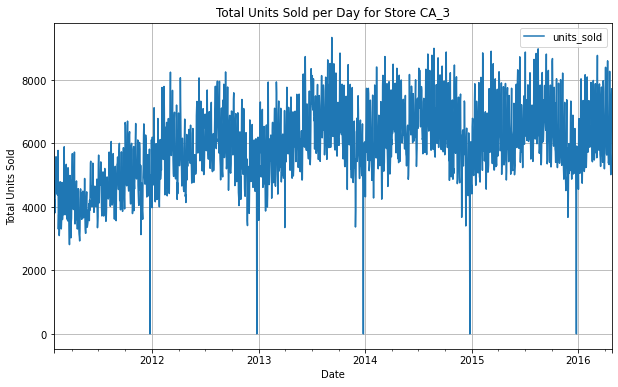

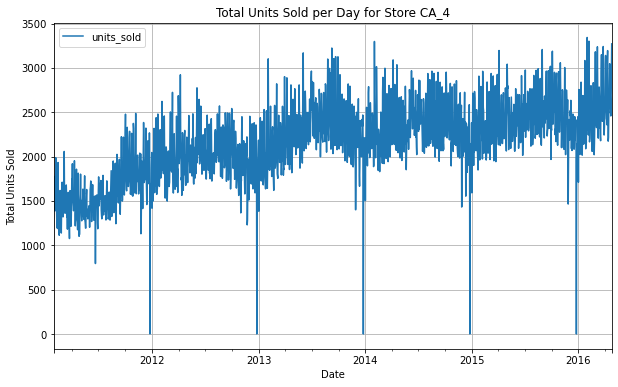

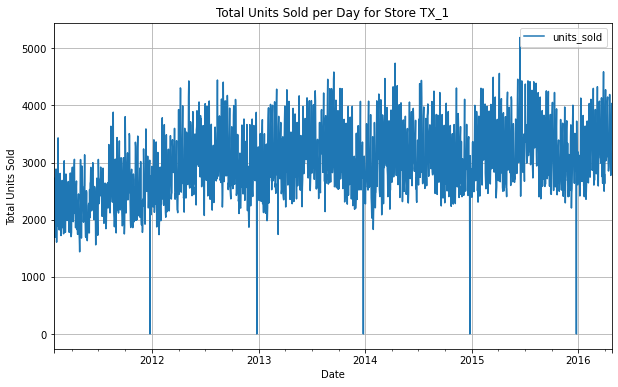

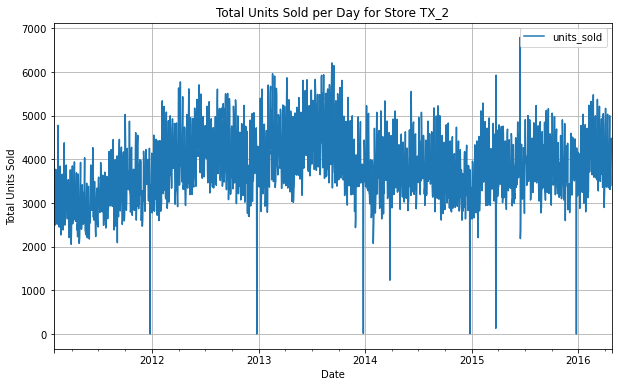

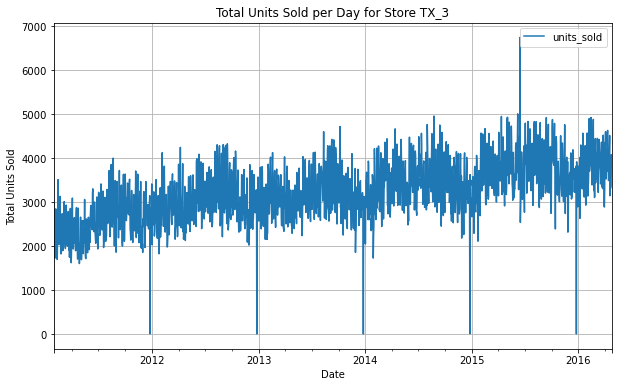

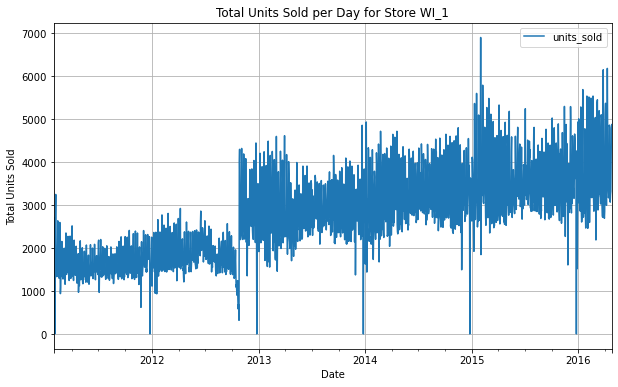

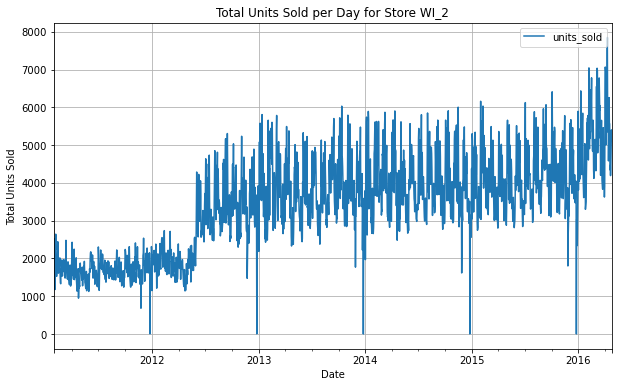

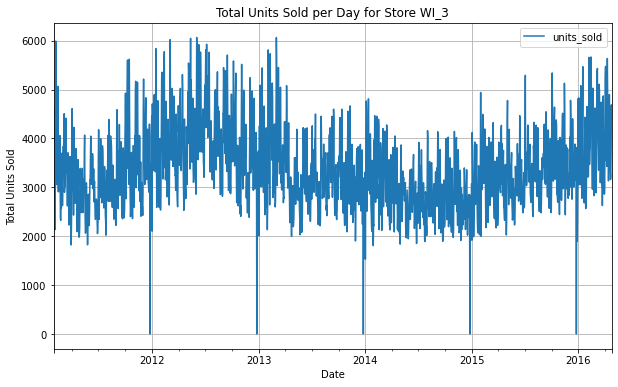

In [57]:
grouped_data_store = sales_df.groupby('store_id')

# Get the unique store IDs
stores = sales_df['store_id'].unique()

# Iterate over each store_id and create a time series plot
for store in stores:
    # Filter the data for the current store_id
    store_data = grouped_data_store.get_group(store)
    
    # Calculate the total units_sold per day
    daily_units_sold = store_data['units_sold'].resample('D').sum()
    
    # Plot the time series
    plt.figure(figsize=(10, 6))
    daily_units_sold.plot()
    
    # Set plot title and labels
    plt.title(f'Total Units Sold per Day for Store {store}')
    plt.xlabel('Date')
    plt.ylabel('Total Units Sold')
    
    # Show legend and grid
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

<span style="font-size: 16px;"> The units sold outlier mentioned in the previous section can be seen again in all three TX stores. So something interesting happened on that day in Texas.</span>

<span id="review-price-data" style="font-size: 16px; font-weight: bold;">CA</span>

In [58]:
ca_stores_data = sales_df[sales_df['store_id'].str.startswith('CA')]
grouped_ca_data = ca_stores_data.groupby('store_id')
ca_stores = ca_stores_data['store_id'].unique().tolist()

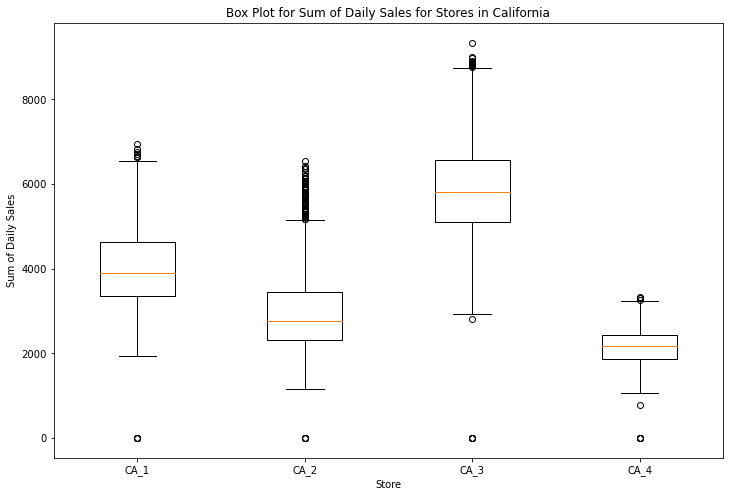

In [59]:
# Create a list to store the sum of daily sales for each store
sum_daily_sales_list = []

# Iterate over each store and calculate the sum of daily sales
for store in ca_stores:
    store_data = grouped_ca_data.get_group(store)
    sum_daily_sales = store_data.resample('D')['units_sold'].sum()
    sum_daily_sales_list.append(sum_daily_sales)

# Plot the box plots for the sum of daily sales
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.boxplot(sum_daily_sales_list)
plt.title('Box Plot for Sum of Daily Sales for Stores in California')
plt.xlabel('Store')
plt.ylabel('Sum of Daily Sales')
plt.xticks(ticks=range(1, len(ca_stores) + 1), labels=ca_stores)
plt.show()

<span id="review-price-data" style="font-size: 16px; font-weight: bold;">TX</span>

In [60]:
TX_stores_data = sales_df[sales_df['store_id'].str.startswith('TX')]
grouped_TX_data = TX_stores_data.groupby('store_id')
TX_stores = TX_stores_data['store_id'].unique().tolist()

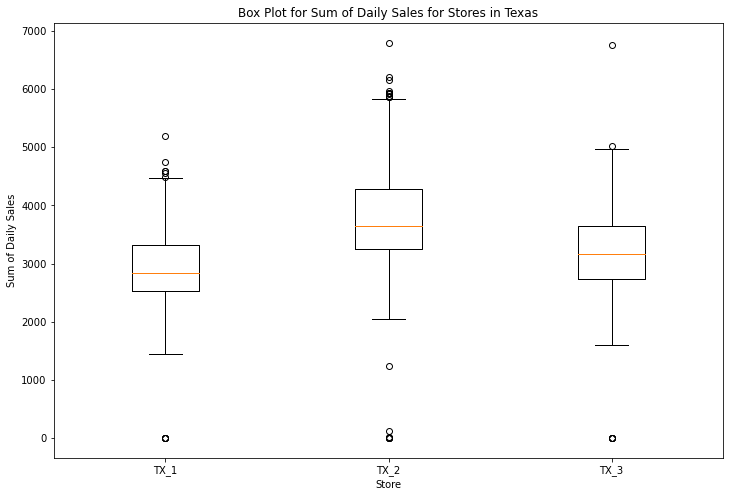

In [61]:
# Create a list to store the sum of daily sales for each store
sum_daily_sales_list_tx = []

# Iterate over each store and TXlculate the sum of daily sales
for store in TX_stores:
    store_data_tx = grouped_TX_data.get_group(store)
    sum_daily_sales_tx = store_data_tx.resample('D')['units_sold'].sum()
    sum_daily_sales_list_tx.append(sum_daily_sales_tx)

# Plot the box plots for the sum of daily sales
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.boxplot(sum_daily_sales_list_tx)
plt.title('Box Plot for Sum of Daily Sales for Stores in Texas')
plt.xlabel('Store')
plt.ylabel('Sum of Daily Sales')
plt.xticks(ticks=range(1, len(TX_stores) + 1), labels=TX_stores)
plt.show()

<span id="review-price-data" style="font-size: 16px; font-weight: bold;">WI</span>

In [62]:
WI_stores_data = sales_df[sales_df['store_id'].str.startswith('WI')]
grouped_WI_data = WI_stores_data.groupby('store_id')
WI_stores = WI_stores_data['store_id'].unique().tolist()

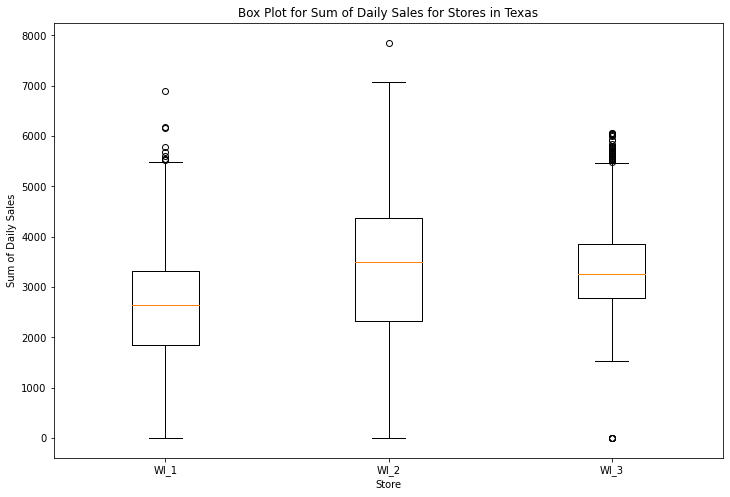

In [63]:
# Create a list to store the sum of daily sales for each store
sum_daily_sales_list_WI = []

# Iterate over each store and WIlculate the sum of daily sales
for store in WI_stores:
    store_data_WI = grouped_WI_data.get_group(store)
    sum_daily_sales_WI = store_data_WI.resample('D')['units_sold'].sum()
    sum_daily_sales_list_WI.append(sum_daily_sales_WI)

# Plot the box plots for the sum of daily sales
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.boxplot(sum_daily_sales_list_WI)
plt.title('Box Plot for Sum of Daily Sales for Stores in Texas')
plt.xlabel('Store')
plt.ylabel('Sum of Daily Sales')
plt.xticks(ticks=range(1, len(WI_stores) + 1), labels=WI_stores)
plt.show()

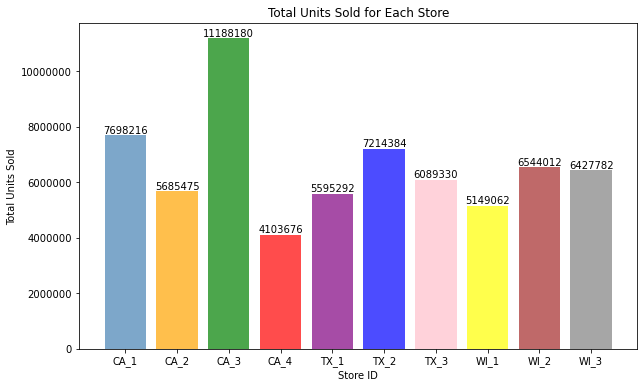

In [64]:
total_units_sold_list = []

# Iterate over each store_id and calculate the total units_sold
for store in stores:
    # Filter the data for the current store_id
    store_data = grouped_data_store.get_group(store)
    
    # Calculate the total units_sold per store
    total_units_sold = store_data['units_sold'].sum()
    
    # Append the total units_sold to the list
    total_units_sold_list.append(total_units_sold)

# Plot the histogram with all stores
plt.figure(figsize=(10, 6))
plt.bar(stores, total_units_sold_list, color=['steelblue', 'orange', 'green', 'red', 'purple', 'blue', 'pink', 'yellow', 'brown', 'gray'], alpha=0.7)

# Set plot title and labels
plt.title('Total Units Sold for Each Store')
plt.xlabel('Store ID')
plt.ylabel('Total Units Sold')

# Format the y-axis tick labels to disable scientific notation
plt.ticklabel_format(style='plain', axis='y')

# Add the total units sold as text on top of each bar
for i, total_units_sold in enumerate(total_units_sold_list):
    plt.text(i, total_units_sold, str(total_units_sold), ha='center', va='bottom')

# Show the plot
plt.show()

In [65]:
sales_df['cash_sales'] = sales_df['units_sold'] * sales_df['sell_price']

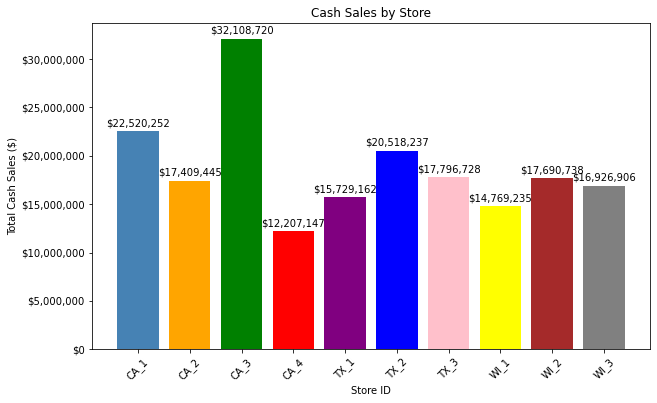

In [66]:
import matplotlib.ticker as ticker
# Define the colors for the bar chart
colors = ['steelblue', 'orange', 'green', 'red', 'purple', 'blue', 'pink', 'yellow', 'brown', 'gray']

# Calculate the sum of cash_sales for each unique store
store_sales = sales_df.groupby('store_id')['cash_sales'].sum()

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(store_sales.index, store_sales.values, color=colors)

# Set labels and title for the chart
ax.set_xlabel('Store ID')
ax.set_ylabel('Total Cash Sales ($)')
ax.set_title('Cash Sales by Store')

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Disable scientific notation
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

# Add labels on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'${height:,.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Display the chart
plt.show()

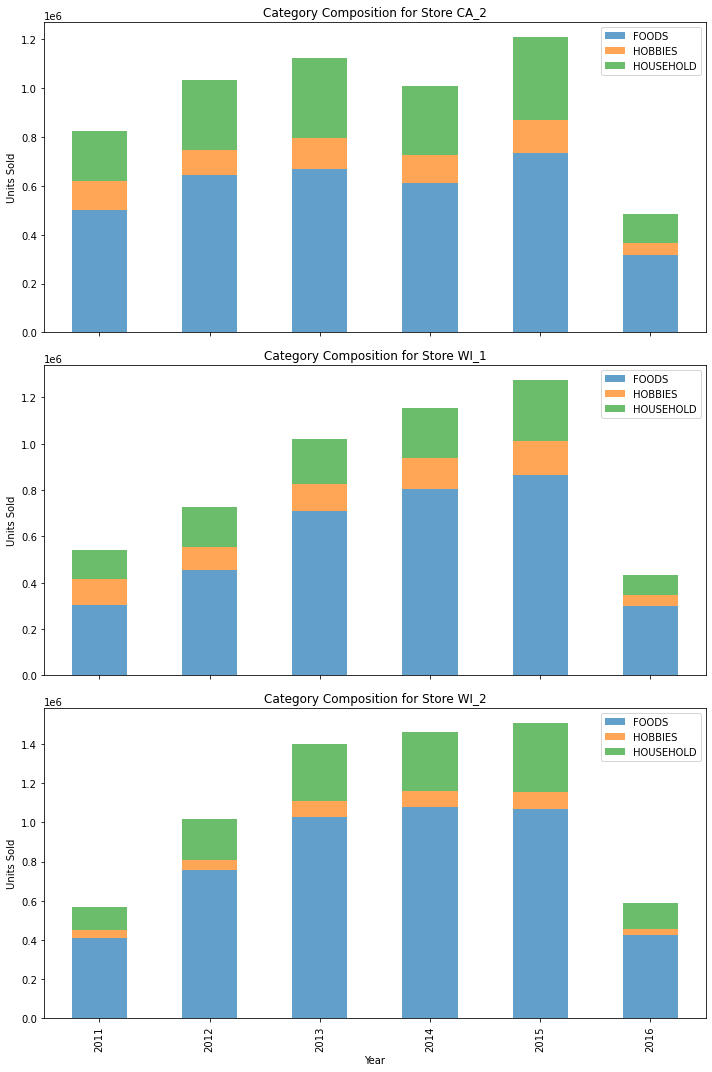

In [67]:
# Define the stores and categories
stores = ['CA_2', 'WI_1', 'WI_2']
categories = sales_df['cat_id'].unique()

# Create subplots for each store
fig, axes = plt.subplots(len(stores), 1, figsize=(10, len(stores) * 5), sharex=True)

# Iterate over each store
for i, store in enumerate(stores):
    # Filter the data for the current store
    store_data = sales_df[sales_df['store_id'] == store]
    
    # Group the data by year and category and calculate the sum of units_sold
    grouped_data = store_data.groupby([store_data.index.year, 'cat_id'])['units_sold'].sum().unstack()
    
    # Plot the stacked bar chart for the store
    grouped_data.plot(kind='bar', stacked=True, ax=axes[i], alpha=0.7)
    
    # Set plot title and labels
    axes[i].set_title(f'Category Composition for Store {store}')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Units Sold')
    
    # Set x-axis tick labels as the year values
    axes[i].set_xticklabels(grouped_data.index)
    
    # Set the legend
    axes[i].legend()
    
# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

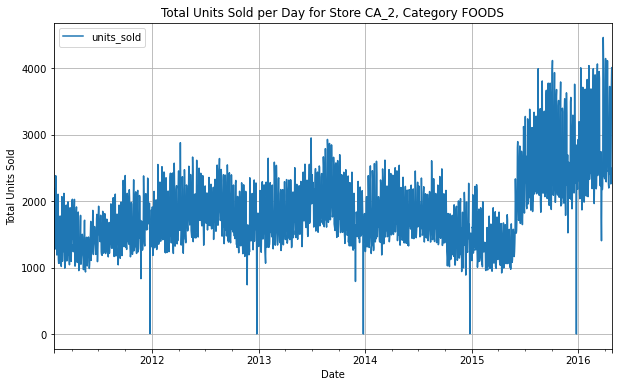

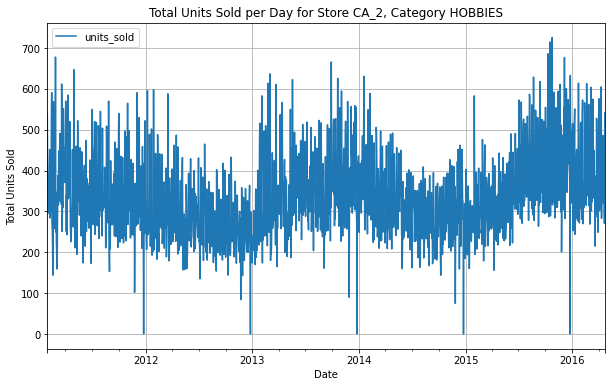

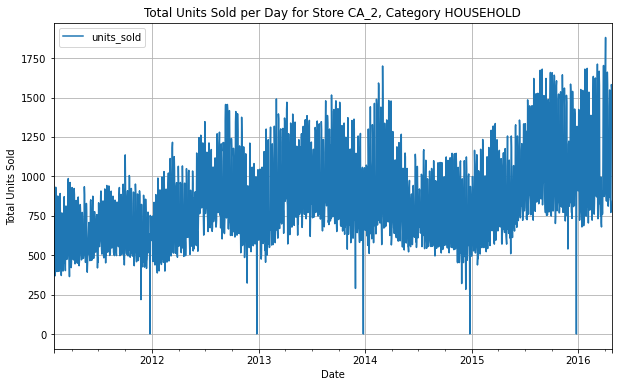

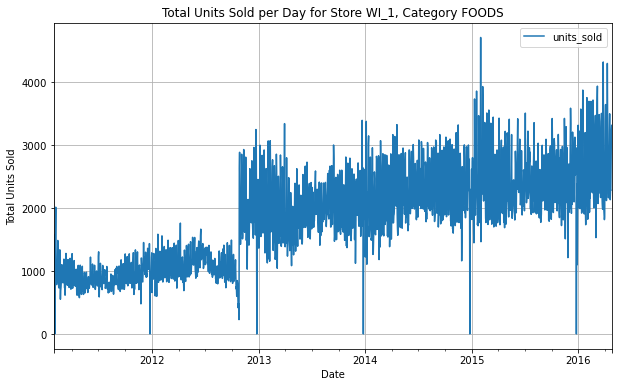

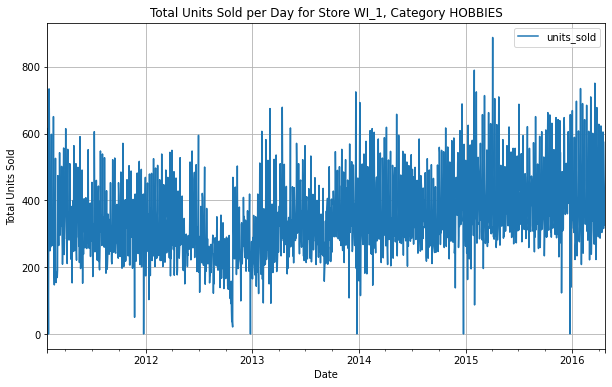

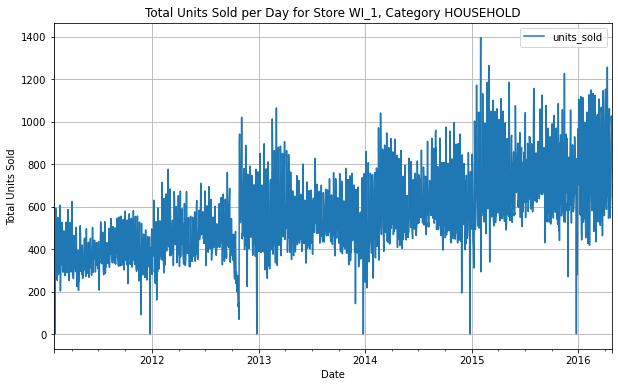

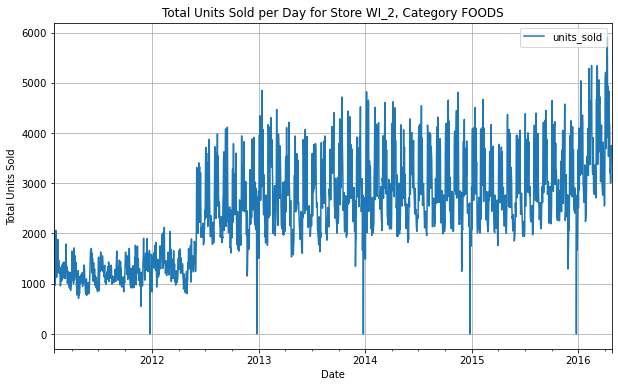

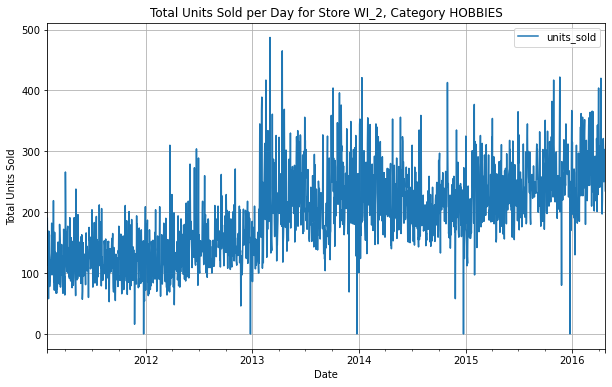

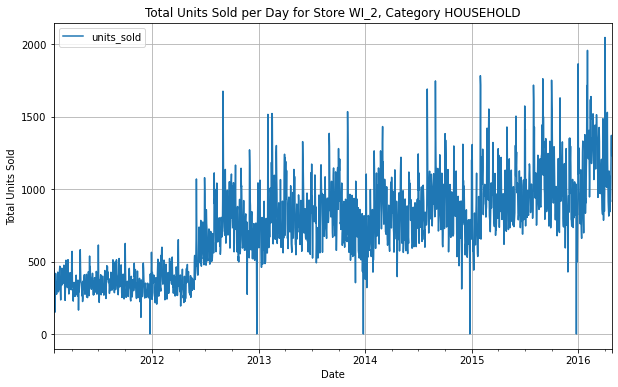

In [68]:
# Group the data by 'store_id' and 'cat_id'
grouped_data_st = sales_df.groupby(['store_id', 'cat_id'])

# Iterate over each group and create a time series plot for the specified stores
for group_name, group_data in grouped_data_st:
    store_id, cat_id = group_name
    
    # Check if the current store is in the desired stores list
    if store_id in stores:
        # Calculate the total units_sold per day
        daily_units_sold = group_data['units_sold'].resample('D').sum()
        
        # Plot the time series
        plt.figure(figsize=(10, 6))
        daily_units_sold.plot()
        
        # Set plot title and labels
        plt.title(f'Total Units Sold per Day for Store {store_id}, Category {cat_id}')
        plt.xlabel('Date')
        plt.ylabel('Total Units Sold')
        
        # Show legend and grid
        plt.legend()
        plt.grid(True)
        
        # Show the plot
        plt.show()

In [69]:
# Group the sales data by store_id and calculate the total units sold for each store
store_sales = sales_df.groupby('store_id')['units_sold'].sum()

# Sort the stores based on total units sold in descending order
sorted_stores = store_sales.sort_values(ascending=False)

# Calculate the cumulative sum of units sold
cumulative_units_sold = sorted_stores.cumsum()

# Calculate the total units sold
total_units_sold = sorted_stores.sum()

# Find the index position where the cumulative sum exceeds or reaches 80% of the total units sold
threshold = 0.8 * total_units_sold
contributing_stores = sorted_stores[cumulative_units_sold <= threshold]

print("Stores contributing to 80% of units sold:")
print(contributing_stores)

Stores contributing to 80% of units sold:
store_id
CA_3    11188180
CA_1     7698216
TX_2     7214384
WI_2     6544012
WI_3     6427782
TX_3     6089330
CA_2     5685475
Name: units_sold, dtype: int64


In [70]:
dept_store_sales = sales_df.groupby(['store_id', 'dept_id'])['units_sold'].sum()

In [71]:
# Filter for combinations with units_sold sum greater than 0
filtered_combinations = dept_store_sales[dept_store_sales > 0]

# Iterate over each combination and print the first date with units_sold greater than 0
for (store_id, dept_id), sum_units_sold in filtered_combinations.iteritems():
    # Filter the original dataframe for the current combination
    filtered_df = sales_df[(sales_df['store_id'] == store_id) & (sales_df['dept_id'] == dept_id)]
    
    # Find the first date with units_sold greater than 0 for the current combination
    first_date_greater_than_zero = filtered_df[filtered_df['units_sold'] > 0].index.min()
    
    # Print the first date, store_id, and dept_id
    print(f"Store ID: {store_id}, Dept ID: {dept_id}")
    print("First Date with Units Sold > 0:")
    print(first_date_greater_than_zero)
    print()

Store ID: CA_1, Dept ID: FOODS_1
First Date with Units Sold > 0:
2011-01-29 00:00:00

Store ID: CA_1, Dept ID: FOODS_2
First Date with Units Sold > 0:
2011-01-29 00:00:00

Store ID: CA_1, Dept ID: FOODS_3
First Date with Units Sold > 0:
2011-01-29 00:00:00

Store ID: CA_1, Dept ID: HOBBIES_1
First Date with Units Sold > 0:
2011-01-29 00:00:00

Store ID: CA_1, Dept ID: HOBBIES_2
First Date with Units Sold > 0:
2011-01-29 00:00:00

Store ID: CA_1, Dept ID: HOUSEHOLD_1
First Date with Units Sold > 0:
2011-01-29 00:00:00

Store ID: CA_1, Dept ID: HOUSEHOLD_2
First Date with Units Sold > 0:
2011-01-29 00:00:00

Store ID: CA_2, Dept ID: FOODS_1
First Date with Units Sold > 0:
2011-01-29 00:00:00

Store ID: CA_2, Dept ID: FOODS_2
First Date with Units Sold > 0:
2011-01-29 00:00:00

Store ID: CA_2, Dept ID: FOODS_3
First Date with Units Sold > 0:
2011-01-29 00:00:00

Store ID: CA_2, Dept ID: HOBBIES_1
First Date with Units Sold > 0:
2011-01-29 00:00:00

Store ID: CA_2, Dept ID: HOBBIES_2
First

<span id="observations-sales-by-store" style="font-size: 16px; font-weight: bold;">Observations: Sales by Store</span>

<span style="font-size: 16px;"> CA_3 emerges as the top-performing store in terms of unit sales, consistently averaging around 6000 units sold per day, significantly higher than the other stores. On the other hand, CA_4 appears to have the lowest unit sales among all the stores.When examining WI_1 in 2012, there is a notable spike in unit sales during the third and fourth quarters. Similarly, WI_2 experiences a surge in sales during the second quarter of 2012. In the case of CA_2, there is a significant increase in sales during the second quarter of 2015.
 </span>

<span style="font-size: 16px;"> In the case of the Wisconsin stores, there appears to be a pattern suggesting the possibility of store remodels or similar events. Across all product categories, there is a noticeable dip in sales for a certain period, followed by a subsequent jump that eventually stabilizes at a higher sales volume. This pattern indicates a potential change or enhancement in the stores' operations or offerings, which could include remodels, expansions, or strategic adjustments to attract more customers and drive sales. </span>

<span style="font-size: 16px;">Regarding the CA store, it appears that the food section was expanded, leading to an overall increase in unit sales. However, when attempting to identify new departments added to stores, it seems that there are sales for every department in every store for the first day in the dataset, making it difficult to pinpoint specific additions. This issue may need to be revisited if necessary for modeling purposes. <span>

<span id="items-by-store" style="font-size: 30px; font-weight: bold;">Top Items </span>

In [72]:
top_items_per_store = sales_df.groupby(['store_id', 'item_id'])['units_sold'].sum().reset_index()
top_items_per_store = top_items_per_store.sort_values(['store_id', 'units_sold'], ascending=[True, False])
top_items_per_store = top_items_per_store.groupby('store_id').head(1)

In [73]:
top_items_per_store

,store_id,item_id,units_sold
702,CA_1,FOODS_3_090,127203
4247,CA_2,FOODS_3_586,63416
6800,CA_3,FOODS_3_090,250502
9849,CA_4,FOODS_3_090,52264
13394,TX_1,FOODS_3_586,112454
16443,TX_2,FOODS_3_586,192835
19492,TX_3,FOODS_3_586,150122
22181,WI_1,FOODS_3_226,78993
25230,WI_2,FOODS_3_226,69966
28143,WI_3,FOODS_3_090,121434


In [74]:
top_items_per_store_category = sales_df.groupby(['store_id', 'cat_id', 'item_id'])['units_sold'].sum().reset_index()
top_items_per_store_category = top_items_per_store_category.sort_values(['store_id', 'cat_id', 'units_sold'], ascending=[True, True, False])
top_items_per_store_category = top_items_per_store_category.groupby(['store_id', 'cat_id']).head(1)

In [75]:
top_items_per_store_category

,store_id,cat_id,item_id,units_sold
702,CA_1,FOODS,FOODS_3_090,127203
4825,CA_1,HOBBIES,HOBBIES_1_348,22744
8213,CA_1,HOUSEHOLD,HOUSEHOLD_1_118,14604
10345,CA_2,FOODS,FOODS_3_586,63416
13647,CA_2,HOBBIES,HOBBIES_1_015,13957
17476,CA_2,HOUSEHOLD,HOUSEHOLD_1_234,15952
18996,CA_3,FOODS,FOODS_3_090,250502
23006,CA_3,HOBBIES,HOBBIES_1_234,29742
26507,CA_3,HOUSEHOLD,HOUSEHOLD_1_118,43351
28143,CA_4,FOODS,FOODS_3_090,52264


<span id="price" style="font-size: 30px; font-weight: bold;">Price </span>

In [76]:
# Group the data by 'item_id' and 'week' with the start day as Saturday
weekly_data2 = sales_df.groupby(['id', pd.Grouper(freq='W-SAT')]).agg({'units_sold': 'sum', 'sell_price': 'mean'})

# Calculate the correlation coefficient and p-value
correlation, p_value = stats.pearsonr(weekly_data2['units_sold'], weekly_data2['sell_price'])

# Print the results
print("Correlation coefficient:", correlation)
print("P-value:", p_value)

Correlation coefficient: -0.058367552155837436
P-value: 0.0


In [77]:
# Group the data by 'id' and calculate the correlation coefficient and p-value for each group
correlation_p_values = weekly_data2.groupby('id').apply(lambda x: stats.pearsonr(x['units_sold'], x['sell_price']))
# Print the correlation coefficient and p-value for each ID
for id, (correlation, p_value) in correlation_p_values.items():
    if correlation <= -0.5 and p_value <= 0.05:
        print("ID:", id)
        print("Correlation coefficient:", correlation)
        print("P-value:", p_value)

C:\Users\brian\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\brian\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


ID: FOODS_1_019_CA_4_validation
Correlation coefficient: -0.5327456032850951
P-value: 1.4579658422289712e-21
ID: FOODS_1_036_WI_1_validation
Correlation coefficient: -0.5161300521558727
P-value: 4.003527369235797e-20
ID: FOODS_1_044_CA_1_validation
Correlation coefficient: -0.5174570784068775
P-value: 3.0932672847951017e-20
ID: FOODS_1_044_TX_2_validation
Correlation coefficient: -0.5162133091019203
P-value: 3.9393882051737874e-20
ID: FOODS_1_054_CA_2_validation
Correlation coefficient: -0.5887680206074338
P-value: 4.766561576835924e-27
ID: FOODS_1_054_CA_3_validation
Correlation coefficient: -0.5373933868571941
P-value: 5.583823435022406e-22
ID: FOODS_1_061_TX_2_validation
Correlation coefficient: -0.5582060452996129
P-value: 6.295635795837063e-24
ID: FOODS_1_061_WI_1_validation
Correlation coefficient: -0.5077557383932089
P-value: 1.9870683062823064e-19
ID: FOODS_1_084_TX_2_validation
Correlation coefficient: -0.659240085801834
P-value: 1.1460848268555005e-35
ID: FOODS_1_086_CA_3_val

Correlation coefficient: -0.5200430334883882
P-value: 1.86510153229104e-20
ID: FOODS_3_587_TX_2_validation
Correlation coefficient: -0.5354802873387372
P-value: 8.30384773586008e-22
ID: FOODS_3_587_WI_2_validation
Correlation coefficient: -0.5086534019223283
P-value: 1.6770457926641327e-19
ID: FOODS_3_611_TX_3_validation
Correlation coefficient: -0.5540784132183372
P-value: 1.5712099457421694e-23
ID: FOODS_3_631_WI_3_validation
Correlation coefficient: -0.5648168446223575
P-value: 1.4166180037666935e-24
ID: FOODS_3_632_CA_1_validation
Correlation coefficient: -0.5050895627340196
P-value: 3.278986808647886e-19
ID: FOODS_3_655_TX_2_validation
Correlation coefficient: -0.5001336148408276
P-value: 8.223585002198788e-19
ID: FOODS_3_655_WI_1_validation
Correlation coefficient: -0.5103741313555471
P-value: 1.2098239050528402e-19
ID: FOODS_3_655_WI_2_validation
Correlation coefficient: -0.5670890326252257
P-value: 8.41846285453547e-25
ID: FOODS_3_664_CA_2_validation
Correlation coefficient: -0

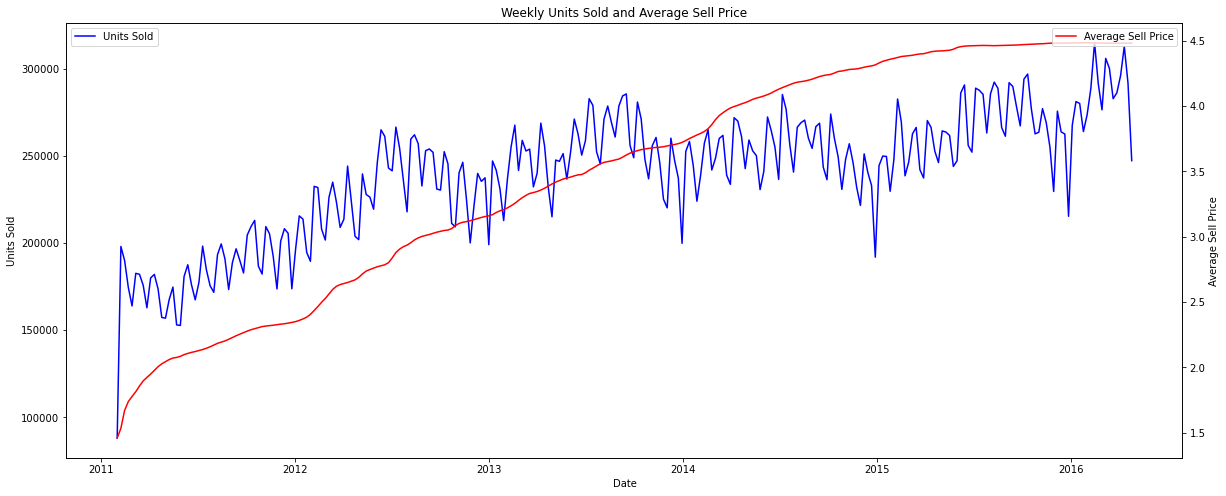

In [78]:
# Calculate the weekly sum of units_sold
weekly_units_sold = sales_df['units_sold'].resample('W-MON').sum()

# Calculate the weekly average sell_price
weekly_avg_sell_price = sales_df['sell_price'].resample('W-MON').mean()

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(20, 8))
ax2 = ax1.twinx()

# Plot the line for units_sold on the first subplot
ax1.plot(weekly_units_sold.index, weekly_units_sold, color='blue', label='Units Sold')
ax1.set_ylabel('Units Sold')

# Plot the line for average sell_price on the second subplot
ax2.plot(weekly_avg_sell_price.index, weekly_avg_sell_price, color='red', label='Average Sell Price')
ax2.set_ylabel('Average Sell Price')

# Set common x-axis label and title
ax1.set_xlabel('Date')
plt.title('Weekly Units Sold and Average Sell Price')

# Show legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

<span id="observations-price" style="font-size: 16px; font-weight: bold;">Observations: Price</span>

<span style="font-size: 16px;"> Based on the analysis of the entire dataset, there is a very slight negative correlation between unit sales and price. This suggests that, overall, the total unit sales might be slightly influenced by changes in sell price. However, when examining individual items across different states, it becomes apparent that there are many cases where increasing the price results in a significant decrease in unit sales. These observations indicate a strong negative relationship between price and unit sales for specific state-item combinations. <span>

<span style="font-size: 16px;"> The graph depicting the relationship between Weekly Units Sold and Average Sell Price provides interesting visual insights, but it lacks practical utility. While the total average weekly sell price exhibits a steady increase over time, there doesn't seem to be a noticeable impact on the weekly sales units. Based on these observations, it can be concluded that while price does have a role in influencing unit sales, its influence appears to be minimal on total sales units.<span>

<span id="seasonal" style="font-size: 30px; font-weight: bold;">Seasonal Decomposition </span> 

In [79]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58327370 entries, 2011-01-29 to 2016-04-24
Data columns (total 20 columns):
 #   Column        Dtype   
---  ------        -----   
 0   id            category
 1   item_id       category
 2   dept_id       category
 3   cat_id        category
 4   state_id      category
 5   day           object  
 6   units_sold    int64   
 7   weekday       category
 8   event_name_1  category
 9   event_type_1  category
 10  event_name_2  category
 11  event_type_2  category
 12  snap_CA       uint8   
 13  snap_TX       uint8   
 14  snap_WI       uint8   
 15  sell_price    float64 
 16  store_id      category
 17  year          int64   
 18  ymd           object  
 19  cash_sales    float64 
dtypes: category(11), float64(2), int64(2), object(2), uint8(3)
memory usage: 3.9+ GB


In [80]:
index_name = sales_df.index.name
print(index_name)

date


<span id="multi" style="font-size: 30px; font-weight: bold;">Multiplicative vs. Additive </span>  

In [81]:
df= sales_df.resample('D').sum()

In [82]:
#Multiplicative Decomposition
mult_result = seasonal_decompose(df['units_sold'], model='multiplicative', period =7)

#Additive Decomposition
add_result= seasonal_decompose(df['units_sold'], model='additive', period =7)

Text(0.5, 0.98, '\nMultiplicative Decompose')

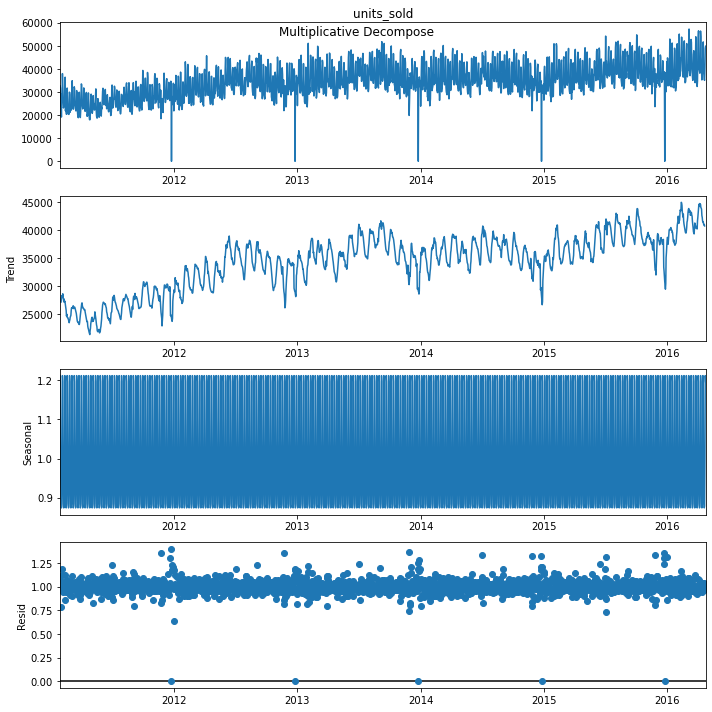

In [83]:
plt.rcParams.update({'figure.figsize': (10,10)})
mult_result.plot().suptitle('\nMultiplicative Decompose', fontsize=12)

Text(0.5, 0.98, '\nAdditive Decompose')

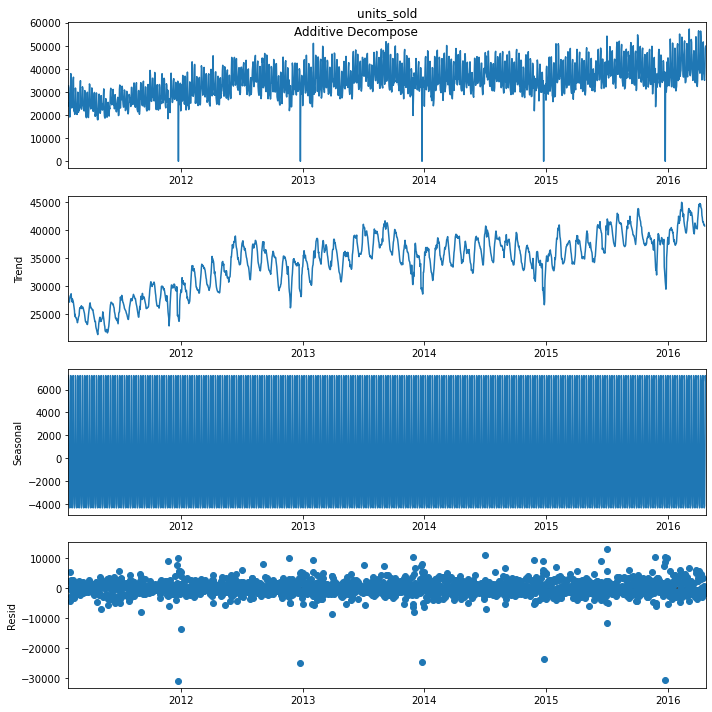

In [84]:
plt.rcParams.update({'figure.figsize': (10,10)})
add_result.plot().suptitle('\nAdditive Decompose', fontsize=12)

In [85]:
# Calculate RMSE for multiplicative decomposition
mult_residuals = df['units_sold'] - mult_result.seasonal - mult_result.trend
mult_rmse = np.sqrt(np.mean(mult_residuals**2))

# Calculate RMSE for additive decomposition
add_residuals = df['units_sold'] - add_result.seasonal - add_result.trend
add_rmse = np.sqrt(np.mean(add_residuals**2))

print(f"RMSE (Multiplicative Decomposition): {mult_rmse}")
print(f"RMSE (Additive Decomposition): {add_rmse}")

RMSE (Multiplicative Decomposition): 5364.208363991188
RMSE (Additive Decomposition): 2662.9876103070005


In [86]:
# Multiplicative Decomposition
mult_result_12 = seasonal_decompose(df['units_sold'], model='multiplicative', period=30)

# Additive Decomposition
add_result_12 = seasonal_decompose(df['units_sold'], model='additive', period=30)

Text(0.5, 0.98, '\nMultiplicative Decompose Monthly')

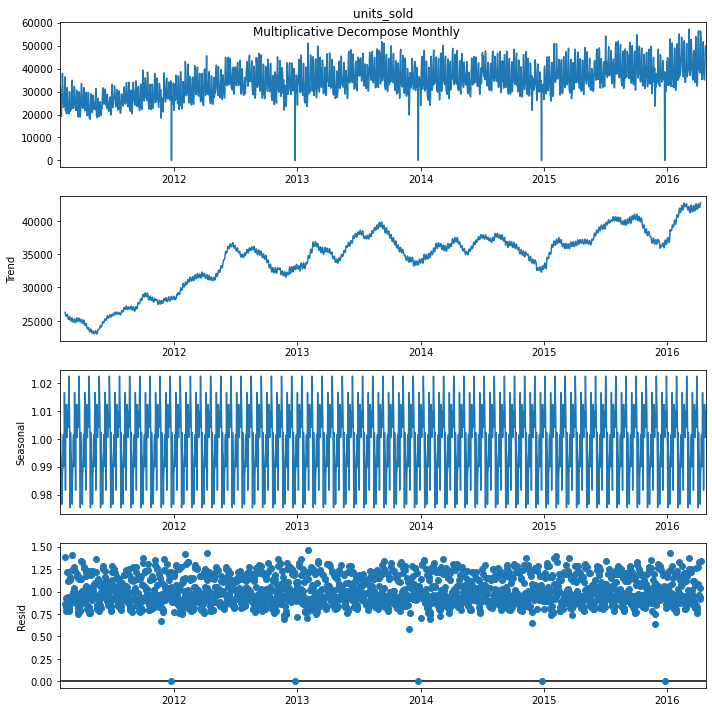

In [87]:
plt.rcParams.update({'figure.figsize': (10,10)})
mult_result_12.plot().suptitle('\nMultiplicative Decompose Monthly', fontsize=12)

Text(0.5, 0.98, '\nAdditive Decompose Monthly')

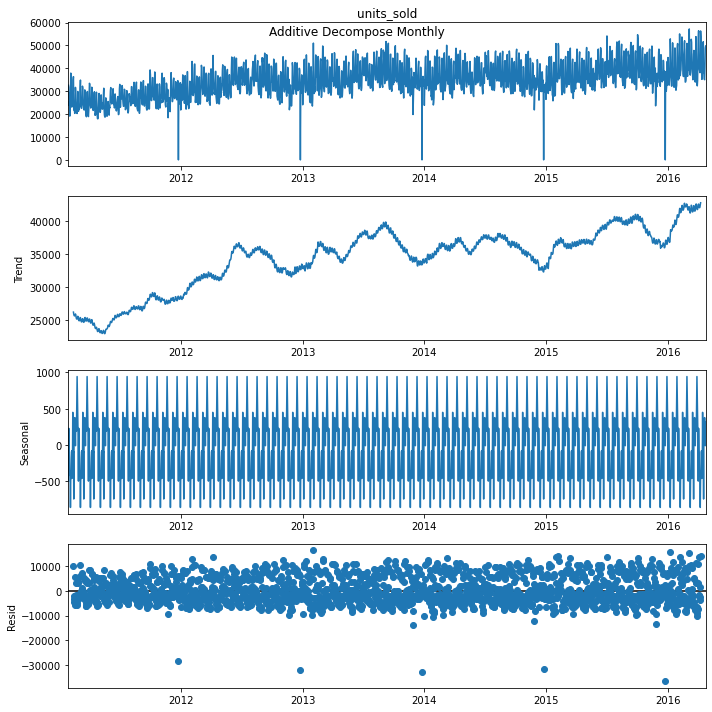

In [88]:
plt.rcParams.update({'figure.figsize': (10,10)})
add_result_12.plot().suptitle('\nAdditive Decompose Monthly', fontsize=12)

In [89]:
# Calculate RMSE for multiplicative decomposition
mult_residuals_monthly = df['units_sold'] - mult_result_12.seasonal - mult_result_12.trend
mult_rmse_monthly = np.sqrt(np.mean(mult_residuals_monthly**2))

# Calculate RMSE for additive decomposition
add_residuals_monthly = df['units_sold'] - add_result_12.seasonal - add_result_12.trend
add_rmse_monthly = np.sqrt(np.mean(add_residuals_monthly**2))

print(f"RMSE (Multiplicative Decomposition): {mult_rmse_monthly}")
print(f"RMSE (Additive Decomposition): {add_rmse_monthly}")

RMSE (Multiplicative Decomposition): 5534.552942939157
RMSE (Additive Decomposition): 5519.180619138373


<span style="font-size: 16px;"> For the period of 30, both decomposition approaches exhibit similar RMSE values, indicating comparable forecast accuracies. This suggests that neither approach significantly outperforms the other in capturing the underlying patterns and making accurate predictions. However, for the period of 7, the additive decomposition yields a substantially lower RMSE compared to the multiplicative decomposition. This implies that the additive decomposition better captures the weekly seasonality pattern in the data and provides more accurate forecasts. Therefore, if the data exhibits a clear weekly seasonality, the additive decomposition with a period of 7 would be a more suitable choice. <span>

<span id="stat" style="font-size: 30px; font-weight: bold;">Stationarity Test </span>  

In [90]:
from statsmodels.tsa.stattools import adfuller

In [91]:
# null hypothesis: non-stationary - if p-value < 5% reject null hypothesis
adfuller_result = adfuller(df.units_sold, autolag='AIC')
print(f'ADF Statistic: {adfuller_result[0]}')
print(f'p=value: {adfuller_result[1]}')
print(f'Number of lags: {adfuller_result[2]}')

for key, value in adfuller_result[4].items():
    print('Critical Values: ')
    print(f'  {key}, {value}')

ADF Statistic: -1.5653733253318471
p=value: 0.5009604361797741
Number of lags: 26
Critical Values: 
  1%, -3.433822016251123
Critical Values: 
  5%, -2.8630736989499335
Critical Values: 
  10%, -2.567586484303047


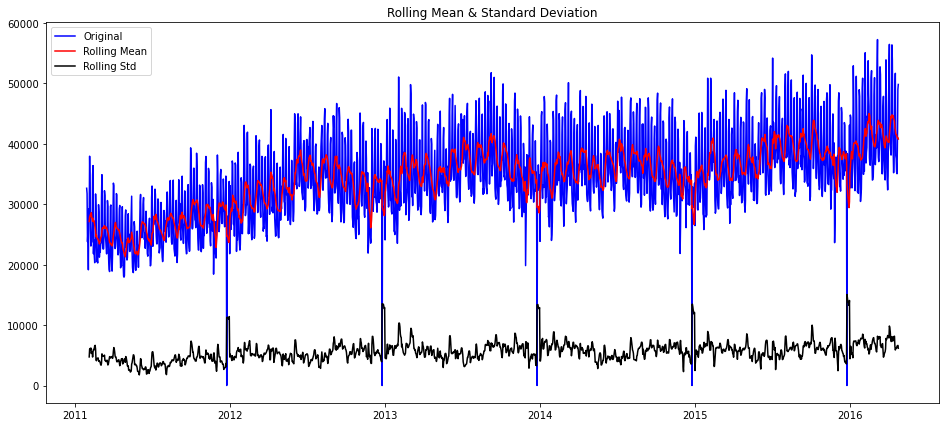

In [92]:
# Calculate rolling mean and standard deviation
rolmean = df['units_sold'].rolling(window=7).mean()
rolstd = df['units_sold'].rolling(window=7).std()

# Plotting the time series data, rolling mean, and rolling standard deviation
plt.figure(figsize=(16, 7))

plt.plot(df['units_sold'], color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std')

plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

<span style="font-size: 16px;"> The ADF statistic is a negative value. In this case, it indicates the presence of some degree of stationarity in the time series. The closer the ADF statistic is to 0, the stronger the evidence of stationarity. The p-value is above the significance level of 0.05 (5%). Therefore, based on the null hypothesis that the time series is non-stationary, we fail to reject the null hypothesis.  If the ADF statistic is more negative than the critical values, it provides stronger evidence of stationarity. In this case, the ADF statistic is less negative than the critical values at all three significance levels, indicating that the evidence of stationarity is not strong.<span>

<span style="font-size: 16px;"> We can see in the graph and dicky fuller test that the time searies is non-stationary and increases with time.<span>

<span id="stattest" style="font-size: 30px; font-weight: bold;">Differencing for stationary </span>  

In [93]:
df_log_diff = np.log(df[['units_sold']]) - np.log(df[['units_sold']]).shift()
df_log_diff = df_log_diff.dropna()

In [94]:
# Perform Dickey-Fuller test
adfuller_result = adfuller(df_log_diff['units_sold'], autolag='AIC')

# Extract the results
adf_statistic = adfuller_result[0]
num_lags = adfuller_result[2]
num_obs = adfuller_result[3]
critical_values = adfuller_result[4]
p_value = adfuller_result[1]

# Display the results
print("Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_statistic}")
print(f"Number of Lags: {num_lags}")
print(f"Number of Observations Used: {num_obs}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")
print(f"P-value: {p_value}")

Dickey-Fuller Test Results:
ADF Statistic: -16.90818687035623
Number of Lags: 26
Number of Observations Used: 1885
Critical Values:
  1%: -3.4338238606869878
  5%: -2.863074513221476
  10%: -2.5675869178703854
P-value: 1.0154501608057459e-29


In [95]:
def time_series_stationary_test(df):

    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))
    
    # Compute rolling mean and rolling standard deviation
    rolling_mean = df.rolling(window=7).mean()
    rolling_std = df.rolling(window=7).std()
    
    # Plotting the original series, rolling mean, and rolling standard deviation
    original_series = df.plot(figsize=(15, 5), alpha=1, lw=1.2,
                              color='blue', label='Original Series', ax=ax1)
    mean_series = rolling_mean.plot(figsize=(15, 5), alpha=1, lw=1.2, marker='o',
                                    color='red', label='Rolling Mean', ax=ax1)
    std_series = rolling_std.plot(figsize=(15, 5), alpha=1, lw=1.2, marker='*',
                                  color='green', label='Rolling Std', ax=ax1)
    
    ax1.legend(['Original_Series', 'Mean_Series', "Std_Series"])
    plt.title('Time Series Plot with Rolling Mean and Standard Deviation')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.show()

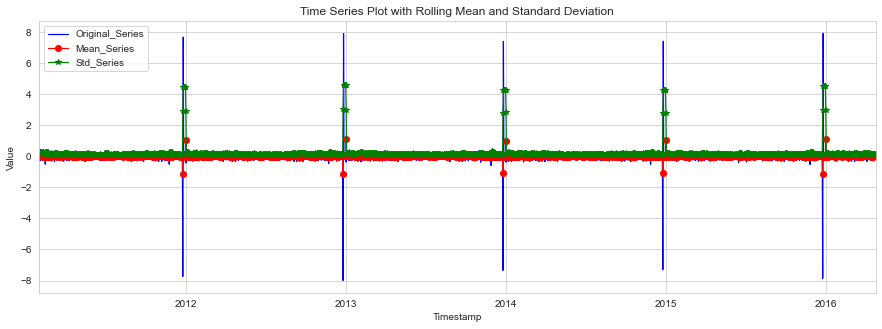

In [96]:
 time_series_stationary_test(df_log_diff)

<span style="font-size: 16px;"> 
Based on the Dickey-Fuller test results, the ADF statistic of -16.90818687035623 indicates strong evidence for stationarity in the time series. The extremely small p-value of 1.0154501608057459e-29 further supports the rejection of the null hypothesis of non-stationarity. Additionally, the ADF statistic being more negative than the critical values at all significance levels provides further confirmation of the stationarity of the time series.<span>

<span id="acf" style="font-size: 30px; font-weight: bold;">ACF and PACF</span>  

In [97]:
def ACF_PCF(ts_stat, nlags=26): 

    lag_acf = acf(ts_stat, nlags)
    lag_pacf = pacf(ts_stat, nlags, method='ols')
    
    sns.set_style("whitegrid")

    
    plt.figure(figsize=(15, 8))
    plt.subplot(121)
    plt.stem(lag_acf)
    plt.axhline(y=0,linestyle='--',color='g')
    plt.axhline(y=-1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.axhline(y=1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.title('Auto-Correlation')
    
    
    plt.subplot(122)
    plt.stem(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='g')
    plt.axhline(y=-1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.axhline(y=1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.title('Partial Auto-Correlation')
    
    plt.show()

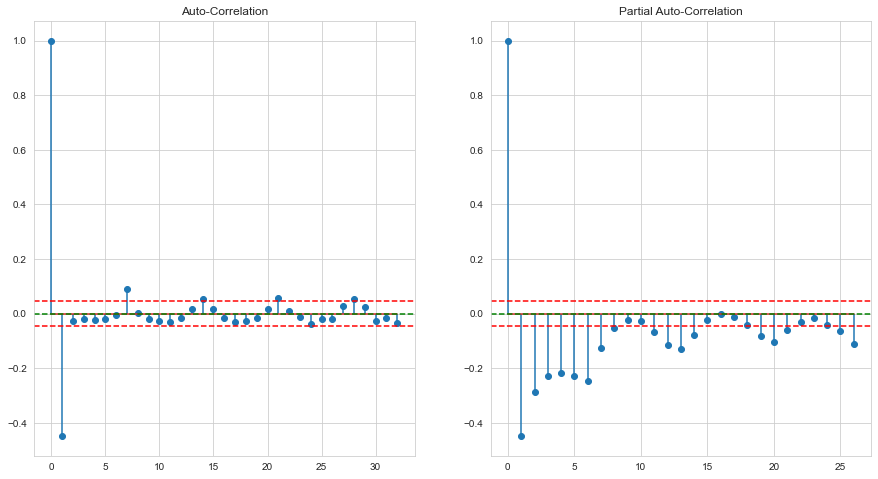

In [98]:
ACF_PCF(df_log_diff, nlags=26)

<span style="font-size: 16px;"> Based on the analysis of the autocorrelation function (ACF) and partial autocorrelation function (PACF) graphs, the recommended inputs for the ARIMA model are as follows: (p=1, d=1, q=2) for the non-seasonal part and (P=1, D=1, Q=0) for the seasonal part. Additionally, the ACF plot indicates a recurring peak at lag 7, suggesting a repeating seasonal pattern in the data.
<span>

<span id="final" style="font-size: 30px; font-weight: bold;">Final Observations</span>  

<span style="font-size: 16px;"> I loaded the dataset and merged them into 'sales_df'. The initial exploration focused on the total daily sales trend for units, revealing a recurring event on Christmas with close to 0 unit sales. The overall trend showed a steady upward growth.
<span>

<span style="font-size: 16px;">Next, I examined category trends and performance, finding that 'foods' dominated, followed by 'household' and 'hobbies'. Notably, 'household' experienced a significant increase in average unit sales in 2012, while 'hobbies' had a similar occurrence in 2013, suggesting significant events in those categories.
<span>

<span style="font-size: 16px;">Analyzing SNAP dates and correlations, I discovered a slight increase in sales on SNAP dates across states.
<span>

<span style="font-size: 16px;">Exploring total unit sales for each store, 'CA_3' emerged as the top-performing store in both unit sales and average sell price. I also identified the stores contributing to 80% of sales, with 7 out of 10 making the list, including 'CA_3', 'CA_1', and 'TX_2'. Examining item IDs, 'FOODS_3_090' stood out as a top-selling item in most stores, with 250,502 total units sold in the top store.
<span>

<span style="font-size: 16px;">Analyzing price and unit sales, I observed that higher prices had a slight negative effect on sales, although the influence varied across items. Overall, the average sell price increased over the years, while total unit sales remained on trend.
<span>

<span style="font-size: 16px;">In the final section, I focused on model tuning. The time series data was determined to be additive and non-stationary, requiring differencing to achieve stationarity. A clear recurring seasonality pattern was observed at lag 7. Inputs for ARIMA models were derived from these analyses, and the plan is to preprocess and test models starting with the Naïve model and moving into ARIMA models, focusing on the top-performing store.
<span>